# Loading Data

## Imports

In [1]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, ReLU, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Activation
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras import metrics
# import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow import keras
import keras_tuner as kt
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, concatenate
import tensorflow as tf

from os.path import join
from os import listdir
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Creating data loaders

In [275]:
IMAGE_SIZE = (64,64)

In [276]:
# ## Separate train and test data

# df = pd.read_csv('.\\final_data.csv',  names=["path","value"])
# len(df)
# import random
# SET = []
# while True:
#     if len(SET) == len(df)//10:
#         break
#     TEMP = random.randint(0,len(df))
#     if TEMP not in SET:
#         SET.append(TEMP)
# TEST = df.iloc[SET]
# TEST.reset_index(drop=True, inplace=True)
# TRAIN = df.drop(SET, axis='index')

# TEST.to_csv("test_data.csv")
# TRAIN.to_csv("train_data.csv")

In [277]:
train = pd.read_csv('.\\train_data.csv',  names=["path","value"])
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range = 0.5,
        height_shift_range = 0.5, 
        zoom_range = [0.7,1.0],
        horizontal_flip = True,
        vertical_flip = True,
        # brightness_range = (0.6,1.0),
        shear_range = 0.5,
        rotation_range = 45,
    ).flow_from_dataframe(
    train, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

test = pd.read_csv('.\\test_data.csv',  names=["path","value"])
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    ).flow_from_dataframe(
    test, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

Found 178 validated image filenames.
Found 20 validated image filenames.


In [278]:
df = pd.read_csv('.\\final_data.csv',  names=["path","value"])
generator = tf.keras.preprocessing.image.ImageDataGenerator(
        # width_shift_range = 0.5,
        # height_shift_range = 0.5, 
        # zoom_range = 0.5,
        # horizontal_flip = True,
        # vertical_flip = True,
        # brightness_range = (0.7,1.0),
        # rotation_range = 45,
    )

data_generator = generator.flow_from_dataframe(
    df, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

Found 198 validated image filenames.


In [279]:
epochs = 128
REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-9)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode="min", restore_best_weights=True)

In [280]:
Xs_TRAIN = []
Ys_TRAIN = []
Xs_TEST = []
Ys_TEST = []
Xs = []
Ys = []
iterations = 4
for i in range(iterations):
    x,y = next(train_generator)
    Xs_TRAIN.extend([np.array(value).astype(int) for value in x])
    Ys_TRAIN.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])
    
    x,y = next(val_generator)
    Xs_TEST.extend([np.array(value).astype(int) for value in x])
    Ys_TEST.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])
    
    x,y = next(data_generator)
    Xs.extend([np.array(value).astype(int) for value in x])
    Ys.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])

In [281]:
MAXPH = np.max(np.array(Ys_TRAIN)[:,1])
MINPH = np.min(np.array(Ys_TRAIN)[:,1])

MAXMOISTURE = np.max(np.array(Ys_TRAIN)[:,0])
MINMOISTURE = np.min(np.array(Ys_TRAIN)[:,0])

In [282]:
print(MAXPH)
print(MINPH)
print(MAXMOISTURE)
print(MINMOISTURE)

5.69
3.53
0.4
0.1


In [283]:

def get_mask(image):
    image = np.array(image, dtype=np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    

    binr = cv2.threshold(gray, 16, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # binr = np.invert(binr)

    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(binr, kernel, iterations=2)
    
    mask = mask // 255
    
    return mask.astype(np.uint8)


In [284]:

def get_mask(image):
    image = image.astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binr = cv2.threshold(gray, 16, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    binr = np.invert(binr)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(binr, kernel, iterations=2)
    mask = (mask // 255).astype(np.uint8)
    return mask

def process_image(image):
    rgb_image = image.astype(np.uint8)
    gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    binr = cv2.threshold(gray, 16, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    binr = np.invert(binr)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(binr, kernel, iterations=2)
    mask = (mask // 255).astype(np.uint8)
    rgb_planes = cv2.split(rgb_image)
    result_planes = []
    for plane in rgb_planes:
        processed_image = cv2.medianBlur(plane, 3)
        processed_image = cv2.bitwise_and(processed_image, processed_image, mask=mask)
        result_planes.append(processed_image)
    result = cv2.merge(result_planes)
    return result


def process_label(image, label, maxPh, minPh, maxMoisture, minMoisture):
    mask = get_mask(np.array(image))
    
    # Ensure mask values are binary (0 or 1)
    mask = (mask).astype(np.uint8)

    # Invert the mask
    inverted_mask = 1 - mask

    # Create arrays for moisture and pH values
    moisture = np.zeros_like(mask, dtype=np.float32)
    ph = np.zeros_like(mask, dtype=np.float32)

    # Normalize the moisture and pH values
    moisture_value = label[0]*10#(label[0] - minMoisture) / (maxMoisture - minMoisture)
    ph_value = label[1]#(label[1] - minPh) / (maxPh - minPh)

    # # Debug prints to check values
    # print("Moisture Value:", moisture_value)
    # print("pH Value:", ph_value)

    # Apply the normalized values where the inverted mask is 1
    moisture[mask == 1] = moisture_value
    ph[mask == 1] = ph_value

    # Stack the moisture and pH arrays along the last axis
    output = np.stack([moisture, ph], axis=-1)

    # # Debug prints to check the mask and output
    # print("Mask:")
    # print(mask)
    # print("Inverted Mask:")
    # print(inverted_mask)
    # print("Output:")
    # print(output)

    # # For debugging: visualizing the mask and the output
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 3, 1)
    # plt.title("Inverted Mask")
    # plt.imshow(inverted_mask, cmap='gray')
    
    # plt.subplot(1, 3, 2)
    # plt.title("Moisture")
    # plt.imshow(moisture, cmap='gray')

    # plt.subplot(1, 3, 3)
    # plt.title("pH")
    # plt.imshow(ph, cmap='gray')
    
    # plt.show()

    return output

In [285]:
# temp = process_label(Xs_TRAIN[NUM], Ys_TRAIN[NUM], MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
# for i in temp:
#     print(i)
# plt.imshow(temp[: ,: ,0], cmap='gray')
# plt.show()
# plt.imshow(Xs_TRAIN[NUM])
# plt.show()

In [286]:
0.30555556 * (float(MAXPH) - float(MINPH)) + float(MINPH)

4.1900000096

In [287]:
0.33333333 * (float(MAXMOISTURE) - float(MINMOISTURE)) + float(MINMOISTURE)

0.199999999

In [288]:
# for i in  process_label(Xs[0], Ys[0],MAXPH, MINPH, MAXMOISTURE, MINMOISTURE):
#     print(i)


In [289]:
# def mask_labels(mask, label):
#     # channel_0 = cv2.bitwise_and(label[:,:], label[:,:], mask=mask)
#     channel_0 = cv2.bitwise_and(label[:,:,0], label[:,:,0], mask=mask)
#     channel_1 = cv2.bitwise_and(label[:,:,1], label[:,:,1], mask=mask)
#     return cv2.merge([channel_0, channel_1])
#     # return cv2.merge([channel_0])

# def unprocess_label(label, maxPh, minPh, maxMoisture, minMoisture):
#     label = np.array(label, dtype=float)
#     non_zero_mask = label >= 0.01
#     filtered_label = label[non_zero_mask]
#     # non_zero_mask = filtered_label >= 0.01
#     # filtered_label = filtered_label[non_zero_mask]
    
#     # for l in filtered_label:
#     #     print(l)

#     if len(filtered_label) % 2 != 0:
#         filtered_label = filtered_label[:-1]  # Remove the last element to make it even

#     moisture = filtered_label[0::2] * (float(maxMoisture) - float(minMoisture)) + float(minMoisture)
#     ph = filtered_label[1::2] * (float(maxPh) - float(minPh)) + float(minPh)

#     # print(moisture)
#     output = [np.mean(moisture), np.mean(ph)]
#     # output = [np.mean(moistusre)]
#     return output

# def unprocess_label_wmask(image,label):
#     unnormalized = np.array(image*255).astype(np.uint8)
#     MASK = np.array(get_mask(unnormalized))
#     mask_label = mask_labels(MASK, np.array(label))
#     results = unprocess_label(mask_label.flatten(), MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
#     return results

In [290]:
def mask_labels(mask, label):
    channel_0 = cv2.bitwise_and(label[:, :, 0], label[:, :, 0], mask=mask)
    channel_1 = cv2.bitwise_and(label[:, :, 1], label[:, :, 1], mask=mask)
    return [channel_0, channel_1]

def unprocess_label(label, maxPh, minPh, maxMoisture, minMoisture):
    # Convert label to float and flatten the arrays
    label = np.array(label, dtype=float)
    label_0_flat = label[0].flatten()
    label_1_flat = label[1].flatten()

    # Filter out zero values
    filtered_label_0 = label_0_flat[label_0_flat != 0]
    filtered_label_1 = label_1_flat[label_1_flat != 0]

    # Unnormalize the values
    moisture = filtered_label_0/10 #* (float(maxMoisture) - float(minMoisture)) + float(minMoisture)
    ph = filtered_label_1 #* (float(maxPh) - float(minPh)) + float(minPh)

    # Return the mean values of moisture and pH
    return [np.mean(moisture), np.mean(ph)]

def unprocess_label_wmask(image, label, mul=1):
    
    
    def make_mask(image):
        image = np.array(image, dtype=np.uint8)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Set pixels with non-zero intensity to 1 and the rest to 0
        mask = (gray > 0).astype(np.uint8)

        # Erode the mask to clean up the edges (optional)
        # kernel = np.ones((3, 3), np.uint8)
        # mask = cv2.erode(mask, kernel, iterations=2)
        
        return mask


    # Unnormalize the image and get the mask
    unnormalized_image = np.array(image * 255).astype(np.uint8)
    mask = make_mask(unnormalized_image)
    # print("Mask shape:", mask.shape)

    # Mask the labels
    masked_labels = mask_labels(mask, np.array(label))

    # Debug prints to check masked labels
    # print("Masked label channel 0:")
    # print(masked_labels[0])
    # print("Masked label channel 1:")
    # print(masked_labels[1])

    # # Visualize the labels
    # plt.imshow(label[:, :, 0])
    # plt.title("Label Channel 0")
    # plt.show()
    # plt.imshow(image)
    # plt.title("Label Channel 0")
    # plt.show()

    # plt.imshow(label[:, :, 1])
    # plt.title("Label Channel 1")
    # plt.show()

    # Unprocess the labels
    results = unprocess_label(masked_labels, MAXPH, MINPH, MAXMOISTURE, MINMOISTURE, mul)
    return results

In [291]:
# unprocess_label_wmask(SAMPLE[NUM],SAMPLE_Y[NUM])

In [292]:
# SAMPLE_Y[NUM]

In [293]:
# NUM=1
# # for i in get_mask(SAMPLE[NUM]):
# #     print(i)
# predictions = modelB.predict(np.array([SAMPLE[NUM]]))
# truth = unprocess_label_wmask(SAMPLE[NUM],SAMPLE_Y[NUM], False)
# pred = unprocess_label_wmask(SAMPLE[NUM],predictions[0], False)
# print("TRUTH moisture: {:.2f}, ph: {:.2f}".format(truth[0],truth[1]))
# print("PREDICTIONS moisture: {:.2f}, ph: {:.2f}".format(pred[0],pred[1]))

In [294]:
# def mask_labels(mask, label):
#     # channel_0 = cv2.bitwise_and(label[:,:], label[:,:], mask=mask)
#     channel_0 = cv2.bitwise_and(label[:,:,0], label[:,:,0], mask=mask)
#     channel_1 = cv2.bitwise_and(label[:,:,1], label[:,:,1], mask=mask)
#     merged_label = cv2.merge([channel_0, channel_1])
#     # non_zero_mask = merged_label != 0
#     # filtered_label = merged_label.flatten()[non_zero_mask]
#     # if len(filtered_label) % 2 != 0:
#     #     filtered_label = filtered_label[:-1] 
#     return merged_label
#     # return cv2.merge([channel_0])

# def unprocess_label(label, maxPh, minPh, maxMoisture, minMoisture):
#     # label = np.array(label, dtype=float)
#     # non_zero_mask = label >= 0.01
#     # filtered_label = label[non_zero_mask]
#     # non_zero_mask = filtered_label >= 0.01
#     # filtered_label = filtered_label[non_zero_mask]
    
#     # for l in filtered_label:
#     #     print(l)

#     # if len(filtered_label) % 2 != 0:
#     #     filtered_label = filtered_label[:-1]  # Remove the last element to make it even
    
#     moisture = label[:,:,0] * (float(maxMoisture) - float(minMoisture)) + float(minMoisture)
#     ph = label[:,:,1] * (float(maxPh) - float(minPh)) + float(minPh)

#     # print(moisture)
#     output = [np.mean(moisture), np.mean(ph)]
#     # output = [np.mean(moistusre)]
#     return output

# def unprocess_label_wmask(image,label):
#     unnormalized = np.array(image*255).astype(np.uint8)
#     MASK = np.array(get_mask(unnormalized))
#     mask_label = mask_labels(MASK, np.array(label))
#     results = unprocess_label(mask_label, MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
#     return results

In [295]:
# NUM=0

# predictions = modelB.predict(np.array([SAMPLE[0]]))
# truth = unprocess_label_wmask(SAMPLE[0],SAMPLE_Y[0])
# pred = unprocess_label_wmask(SAMPLE[0],predictions[0])
# print("TRUTH moisture: {:.2f}, ph: {:.2f}".format(truth[0],truth[1]))
# print("PREDICTIONS moisture: {:.2f}, ph: {:.2f}".format(pred[0],pred[1]))

In [296]:
# def get_accuracy(truths, predictions):
#     true_moisture, true_ph = unprocess_label(truths,MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
#     predicted_moisture, predicted_ph = unprocess_label(predictions,MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
#     accuracy_moisture = (1 - abs(true_moisture - predicted_moisture) / true_moisture) * 100
#     accuracy_ph = (1 - abs(true_ph - predicted_ph) / true_ph) * 100
#     return accuracy_moisture,accuracy_ph

# def get_model_accuracy(model, x_values, y_values, copy=[]):
#     predictions = model.predict(x_values)
#     samples = []
#     for i in copy:
#         samples.extend(i)
#     total_acc = []
#     for i,pred in enumerate(predictions):
#         unnormalized = np.array(samples[i]*255)
#         MASK = np.array(get_mask(unnormalized))
#         mask_truth = mask_labels(MASK, np.array(y_values[i]))
#         mask_predictions = mask_labels(MASK, np.array(predictions[i]))
#         total_acc.append(get_accuracy(mask_truth, mask_predictions))
#     return np.mean(total_acc[0]),np.mean(total_acc[1])

# def get_accuracy(truths, predictions):
#     true_moisture = unprocess_label(truths,MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
#     predicted_moisture = unprocess_label(predictions,MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
#     accuracy_moisture = (1 - abs(true_moisture - predicted_moisture) / true_moisture) * 100
#     # accuracy_ph = (1 - abs(true_ph - predicted_ph) / true_ph) * 100
#     return accuracy_moisture

# def get_model_accuracy(model, x_values, y_values, copy=[]):
#     predictions = model.predict(x_values)
#     samples = []
#     for i in copy:
#         samples.extend(i)
#     total_acc = []
#     for i,pred in enumerate(predictions):
#         unnormalized = np.array(samples[i]*255)
#         MASK = np.array(get_mask(unnormalized))
#         mask_truth = mask_labels(MASK, np.array(y_values[i]))
#         mask_predictions = mask_labels(MASK, np.array(predictions[i]))
#         total_acc.append(get_accuracy(mask_truth, mask_predictions))
#     return np.mean(total_acc[0])

In [297]:


# def process_label(image, label, maxPh, minPh, maxMoisture, minMoisture):
#     # mask = get_mask(np.array(image))
#     # shape = mask.shape 
#     # array = np.ones(shape=(shape[0], shape[1], 1))

#     # moisture = cv2.bitwise_and(array, array, mask=mask)
#     # ph = cv2.bitwise_and(array, array, mask=mask)

#     moisture_value = (label[0] - minMoisture) / (maxMoisture - minMoisture)
#     ph_value = (label[1] - minPh) / (maxPh - minPh)
#     # moisture[moisture > 0] = moisture_value
#     # ph[ph > 0] = ph_value

#     output = np.stack([moisture_value, ph_value], axis=-1)  

#     return output

# def process_label(image, label, maxPh, minPh, maxMoisture, minMoisture):
#     mask = get_mask(np.array(image))
#     shape = mask.shape 
#     array = np.ones(shape=(shape[0], shape[1], 1))

#     moisture = cv2.bitwise_and(array, array, mask=mask)
#     ph = cv2.bitwise_and(array, array, mask=mask)

#     # moisture_value = (label[0] - minMoisture) / (maxMoisture - minMoisture)
#     # ph_value = (label[1] - minPh) / (maxPh - minPh)
#     moisture_value = label[0] * 100
#     ph_value = label[1]
#     moisture[moisture > 0] = moisture_value
#     ph[ph > 0] = ph_value

#     output = np.stack([moisture, ph], axis=-1)  

#     return output


# def process_label(image, label, maxPh, minPh, maxMoisture, minMoisture):
#     mask = get_mask(np.array(image))
#     shape = mask.shape 
#     array = np.ones(shape=(shape[0], shape[1], 1))

#     moisture = cv2.bitwise_and(array, array, mask=mask)
#     ph = cv2.bitwise_and(array, array, mask=mask)

#     # moisture_value = (label[0] - minMoisture) / (maxMoisture - minMoisture)
#     # ph_value = (label[1] - minPh) / (maxPh - minPh)
#     moisture_value = label[0] * 100
#     ph_value = label[1]
#     moisture[moisture > 0] = moisture_value
#     ph[ph > 0] = ph_value

#     output = np.stack([moisture, ph], axis=-1)  

#     return output


In [298]:
X_train = []
X_test = []
y_train = []
y_test = []
for i, x in enumerate(Xs_TRAIN):
    y_train.append(process_label(Xs_TRAIN[i], Ys_TRAIN[i], MAXPH, MINPH, MAXMOISTURE, MINMOISTURE))
    X_train.append(process_image(Xs_TRAIN[i]))

for i, x in enumerate(Xs_TEST):
    y_test.append(process_label(Xs_TEST[i], Ys_TEST[i], MAXPH, MINPH, MAXMOISTURE, MINMOISTURE))
    X_test.append(process_image(Xs_TEST[i]))

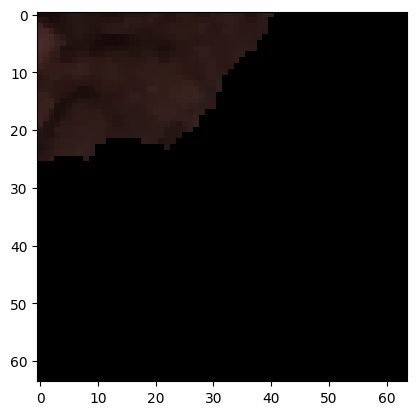

In [299]:
plt.imshow(np.array(X_train)[11])

In [300]:
# np.array(y_train)[11][: ,: ,0]

In [301]:


# from sklearn.model_selection import train_test_split 
# X_train, X_test, y_train, y_test = train_test_split(X_values,Y_values , 
#                                    test_size=0.20,  
#                                    shuffle=True) 

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    ).flow(x=np.array(X_train), y=np.array(y_train), batch_size=4) 

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    ).flow(x=np.array(X_test), y=np.array(y_test), batch_size=4) 

In [340]:
## Prepare set of x values and y values
X_values_1,y_values_1 = [],[]
for i in range(712//4):
    values = next(train_generator)
    X_values_1.append(values[0]) 
    y_values_1.append(values[1])

## create X_values generator
gen_X_values_1_1 = (x for x in X_values_1)
gen_X_values_2_1 = (x for x in X_values_1)
gen_X_values_3_1 = (x for x in X_values_1)
y_values_1 = [y  for y_set in y_values_1 for y in y_set]

## Prepare set of x values and y values
X_values_2,y_values_2 = [],[]
for i in range(80//4):
    values = next(val_generator)
    X_values_2.append(values[0])
    y_values_2.append(values[1])

## create X_values generator
gen_X_values_1_2 = (x for x in X_values_2)
gen_X_values_2_2 = (x for x in X_values_2)
gen_X_values_3_2 = (x for x in X_values_2)
y_values_2 = [y  for y_set in y_values_2 for y in y_set]

SAMPLE = []
SAMPLE_Y = []
SET = 80//4
for i in range(SET):
    TEMP = next(val_generator)
    SAMPLE.extend(TEMP[0])
    SAMPLE_Y.extend(TEMP[1])
    

In [303]:
len(X_train)

712

In [304]:
len(X_test)

80

In [305]:
# TESTER = next(train_generator)[1][1]
# for i in unprocess_label(TESTER.flatten(), MAXPH, MINPH, MAXMOISTURE, MINMOISTURE):
#     print(i)

In [306]:
for i in next(train_generator)[1][0]:
    print(i)

[[1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]]
[[1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46]
 [1.9  4.46

In [307]:
POG = 5

In [308]:
np.array(y_train)[POG]

array([[[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [0. , 0. ],
        [0. , 0. ],
        [0. , 0. ]],

       [[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [0. , 0. ],
        [0. , 0. ],
        [0. , 0. ]],

       [[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [0. , 0. ],
        [0. , 0. ],
        [0. , 0. ]],

       ...,

       [[2.3, 4.8],
        [2.3, 4.8],
        [2.3, 4.8],
        ...,
        [0. , 0. ],
        [0. , 0. ],
        [0. , 0. ]],

       [[2.3, 4.8],
        [2.3, 4.8],
        [2.3, 4.8],
        ...,
        [0. , 0. ],
        [0. , 0. ],
        [0. , 0. ]],

       [[2.3, 4.8],
        [2.3, 4.8],
        [2.3, 4.8],
        ...,
        [0. , 0. ],
        [0. , 0. ],
        [0. , 0. ]]], dtype=float32)

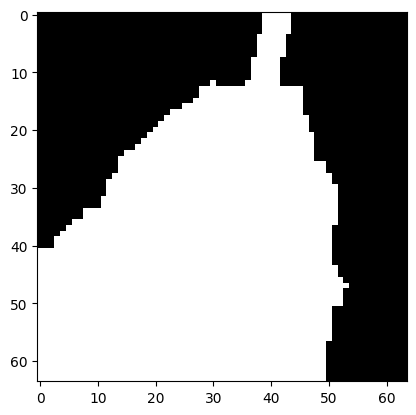

In [309]:
plt.imshow(np.array(y_train)[POG][: ,: ,0], cmap='gray')

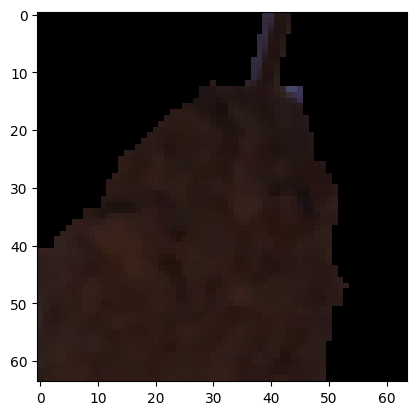

In [310]:
plt.imshow(np.array(X_train)[POG])

In [311]:
next(train_generator)[1][0]

array([[[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [1.4, 4.5],
        [1.4, 4.5],
        [1.4, 4.5]],

       [[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [1.4, 4.5],
        [1.4, 4.5],
        [1.4, 4.5]],

       [[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [1.4, 4.5],
        [1.4, 4.5],
        [1.4, 4.5]],

       ...,

       [[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [1.4, 4.5],
        [1.4, 4.5],
        [1.4, 4.5]],

       [[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [1.4, 4.5],
        [1.4, 4.5],
        [1.4, 4.5]],

       [[0. , 0. ],
        [0. , 0. ],
        [0. , 0. ],
        ...,
        [1.4, 4.5],
        [1.4, 4.5],
        [1.4, 4.5]]], dtype=float32)

In [312]:
x_col = "path"
y_col = "pH"
batch_size = 16
epochs = 1024
lr = 1e-5
image_size = (IMAGE_SIZE[0],IMAGE_SIZE[1])
channels = 3
shuffle = True
class_mode ="raw"
color_mode = "rgb"

# Evaluation of Designs

In [185]:
import tensorflow as tf
from tensorflow.keras import backend as K

def mean_squared_error(y_true, y_pred):
    """Computes the mean squared error between labels and predictions with binarization.

    After computing the squared distance between the inputs, the mean value over
    the last dimension is returned. Binarization is performed on `y_pred` and `y_true`
    based on values > 0 in `y_true`.

    Args:
      y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
      y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
      Mean squared error values. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    # Binarize based on values > 0 in y_true
    binary_mask = tf.cast(y_true > 0, y_pred.dtype)
    y_true = y_true * binary_mask
    y_pred = y_pred * binary_mask
    
    return K.mean(tf.math.squared_difference(y_pred, y_true), axis=[1,2,3])

# Usage example
# y_true = np.random.randint(0, 2, size=(2, 128, 128, 2))
# y_pred = np.random.random(size=(2, 128, 128, 2))
# loss = mean_squared_error(y_true, y_pred)
# print(loss.shape)
# print(loss.numpy())


## Optimization of Designs

### Design A

In [186]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.initializers import HeNormal

# def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
#     x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     return x

# def upsample_block(inputs, skip_features, num_filters):
#     x = UpSampling2D((2, 2))(inputs)
#     x = Conv2D(num_filters, (2, 2), padding="same")(x)
#     x = Concatenate()([x, skip_features])
#     x = convolution_block(x, num_filters)
#     return x

# def dense_upsampling_block(inputs, skip_features, num_filters):
#     x = UpSampling2D((2, 2))(inputs)
#     x = Conv2D(num_filters, (2, 2), padding="same")(x)
#     x = Concatenate()([x, skip_features])
#     x = convolution_block(x, num_filters)
#     return x

# def unet_plus_plus_model(hp,input_shape=(64,64,3)):
#     inputs = Input(input_shape)

#     resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
#     resnet50.trainable = True

#     # Encoder
#     s1 = resnet50.get_layer("conv1_relu").output
#     s2 = resnet50.get_layer("conv2_block3_out").output
#     s3 = resnet50.get_layer("conv3_block4_out").output
#     s4 = resnet50.get_layer("conv4_block6_out").output

#     b1 = resnet50.get_layer("conv5_block3_out").output
#     # Flatten the bottleneck output
#     x = Flatten()(b1);UNITS = hp.Choice('units',values = [256,512,1024,2048]);DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1)
    
#     BATCHNORM = hp.Boolean('batchnorm',default=False)
#     # Dense layers between encoder and decoder
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     # Reshape back to spatial dimensions for the decoder
#     SIZE = input_shape[0] // 32  # Assuming input size is a multiple of 32
#     if BATCHNORM:
#         x = BatchNormalization()(x)
#     x = Dense(SIZE * SIZE * 2048, activation='relu')(x)
#     x = Reshape((SIZE, SIZE, 2048))(x)

#     # Nested U-Net
#     d4_2 = dense_upsampling_block(x, s4, 512)
#     d3_2 = dense_upsampling_block(d4_2, s3, 256)
#     d2_2 = dense_upsampling_block(d3_2, s2, 128)
#     d1_2 = dense_upsampling_block(d2_2, s1, 64)

#     d4_1 = upsample_block(x, s4, 512)
#     d3_1 = upsample_block(d4_1, s3, 256)
#     d2_1 = upsample_block(d3_1, s2, 128)
#     d1_1 = upsample_block(d2_1, s1, 64)

#     outputs = UpSampling2D()(d1_1)
#     outputs = Conv2D(2, (1, 1), padding="same", activation="sigmoid")(outputs)
#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
    
#     # Hyperparameter choice for optimizer
#     optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    
#     # Select optimizer
#     if optimizer_choice == 'adam':
#         optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
#     elif optimizer_choice == 'sgd':
#         optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
#     elif optimizer_choice == 'rmsprop':
#         optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    
#     model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['acc'])
#     return model

# # # Define input shape and build model
# # input_shape = (256, 256, 3)
# # model = build_resnet50_unetpp(input_shape)
# # model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# # # Print model summary
# # model.summary()


In [187]:
# # Defining the Convolutional Block
# def conv_block(inputs, num_filters):
# 	# Applying the sequence of Convolutional, Batch Normalization
# 	# and Activation Layers to the input tensor
# 	x = Sequential([
# 		# Convolutional Layer
# 		Conv2D(num_filters, 1, padding='same'),
# 		# Batch Normalization Layer
# 		BatchNormalization(),
# 		# Activation Layer
# 		ReLU(),
# 		# Convolutional Layer
# 		Conv2D(num_filters, 1, padding='same'),
# 		# Batch Normalization Layer
# 		BatchNormalization(),
# 		# Activation Layer
# 		ReLU()
# 	])(inputs)

# 	# Returning the output of the Convolutional Block
# 	return x
# def dense_block(units, dropout_rate):
#     return Sequential([
#         Dense(units, activation='relu'),
#     ])
# # Defining the Unet++ Model
# def unet_plus_plus_model(hp):
# 	inputs = Input(shape=image_size+(3,))
# 	hp_filters = hp.Choice('filters',values = [16,32,64])
# 	# Encoding Path
# 	x_00 = conv_block(inputs, hp_filters)
# 	x_10 = conv_block(MaxPooling2D()(x_00), hp_filters*2)
# 	x_20 = conv_block(MaxPooling2D()(x_10), hp_filters*4)
# 	x_30 = conv_block(MaxPooling2D()(x_20), hp_filters*8)
# 	x_40 = conv_block(MaxPooling2D()(x_30), hp_filters*16)
	
# 	hp.Boolean("dropouts", default=False)
# 	hp.Boolean("batch_normalization", default=False)
# 	flattened = Flatten()(x_40)
# 	dense = dense_block(hp_filters*hp_filters, 0.2)(flattened)
# 	if hp.Boolean("dropouts"):
# 		dense = tf.keras.layers.Dropout(0.5)(dense)
# 	if hp.Boolean("batch_normalization"):
# 		dense = tf.keras.layers.BatchNormalization()(dense)
# 	dense = dense_block(hp_filters*hp_filters, 0.2)(dense)
# 	if hp.Boolean("dropouts"):
# 		dense = tf.keras.layers.Dropout(0.5)(dense)
# 	if hp.Boolean("batch_normalization"):
# 		dense = tf.keras.layers.BatchNormalization()(dense)
# 	dense = dense_block(hp_filters*hp_filters, 0.2)(dense);hp.Boolean("4th dense", default=False);
# 	if hp.Boolean("4th dense"):
# 		dense = dense_block(hp_filters*hp_filters, 0.2)(dense)
# 		if hp.Boolean("dropouts"):
# 			dense = tf.keras.layers.Dropout(0.5)(dense)
# 		if hp.Boolean("batch_normalization"):
# 			dense = tf.keras.layers.BatchNormalization()(dense)
# 	# dense = dense_block(4096, 0.2)(dense)
# 	# dense = dense_block(4096, 0.2)(dense)
# 	reshaped = tf.keras.layers.Reshape((x_40.shape[1], x_40.shape[1], (hp_filters*hp_filters)//(x_40.shape[1]*x_40.shape[1])))(dense)  # Reshape to reintroduce spatial dimensions


# 	# Nested Decoding Path
# 	x_01 = conv_block(concatenate(
# 		[x_00, UpSampling2D()(x_10)]), hp_filters)
# 	x_11 = conv_block(concatenate(
# 		[x_10, UpSampling2D()(x_20)]), hp_filters*2)
# 	x_21 = conv_block(concatenate(
# 		[x_20, UpSampling2D()(x_30)]), hp_filters*4)
# 	x_31 = conv_block(concatenate(
# 		[x_30, UpSampling2D()(reshaped)]), hp_filters*8)

# 	x_02 = conv_block(concatenate(
# 		[x_00, x_01, UpSampling2D()(x_11)]), hp_filters)
# 	x_12 = conv_block(concatenate(
# 		[x_10, x_11, UpSampling2D()(x_21)]), hp_filters*2)
# 	x_22 = conv_block(concatenate(
# 		[x_20, x_21, UpSampling2D()(x_31)]), hp_filters*4)

# 	x_03 = conv_block(concatenate(
# 		[x_00, x_01, x_02, UpSampling2D()(x_12)]), hp_filters)
# 	x_13 = conv_block(concatenate(
# 		[x_10, x_11, x_12, UpSampling2D()(x_22)]), hp_filters*2)

# 	x_04 = conv_block(concatenate(
# 		[x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), hp_filters)
	
# 	outputs = tf.keras.layers.Conv2D(2, 1, activation='linear')(x_04);print(outputs.shape)

# 	# Creating the model
# 	model = tf.keras.Model(
# 		inputs=inputs, outputs=outputs, name='Unet_plus_plus');lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]);model.compile(optimizer= tf.keras.optimizers.Adam(lr=lr), loss= ["mse"], metrics=['mae'])
# 	# Returning the model
# 	return model




In [188]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
# from tensorflow.keras.initializers import HeNormal

# resnet50 = ResNet50(include_top=False, weights='imagenet')
# print(resnet50.summary())

In [189]:
# # Define the convolutional block
# def conv_block(inputs, num_filters):
#     x = Sequential([
#         Conv2D(num_filters, 3, padding='same'),
#         BatchNormalization(),
#         ReLU(),
#         Conv2D(num_filters, 3, padding='same'),
#         BatchNormalization(),
#         ReLU()
#     ])(inputs)
#     return x

# # Define the dense block
# def dense_block(units, dropout_rate):
#     return Sequential([
#         Dense(units, activation='relu'),
#         Dropout(dropout_rate)
#     ])

# # Define the Unet++ model
# def unet_plus_plus_model(hp, image_size=(224, 224)):
#     inputs = Input(shape=image_size + (3,))

#     # Load ResNet50 as encoder
#     resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
#     encoder_layers = [resnet.get_layer(name).output for name in ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']]
    
#     # Encoding path
#     x_00 = encoder_layers[0]
#     x_10 = encoder_layers[1]
#     x_20 = encoder_layers[2]
#     x_30 = encoder_layers[3]
#     x_40 = encoder_layers[4]

#     flattened = Flatten()(x_40)
#     dense = dense_block(2048, 0.2)(flattened)
#     if hp.Boolean("dropouts"):
#         dense = Dropout(0.5)(dense)
#     if hp.Boolean("batch_normalization"):
#         dense = BatchNormalization()(dense)
#     dense = dense_block(2048, 0.2)(dense)
#     if hp.Boolean("dropouts"):
#         dense = Dropout(0.5)(dense)
#     if hp.Boolean("batch_normalization"):
#         dense = BatchNormalization()(dense)
#     dense = dense_block(2048, 0.2)(dense)
#     if hp.Boolean("4th_dense"):
#         dense = dense_block(2048, 0.2)(dense)
#         if hp.Boolean("dropouts"):
#             dense = Dropout(0.5)(dense)
#         if hp.Boolean("batch_normalization"):
#             dense = BatchNormalization()(dense)

#     reshaped = Reshape((x_40.shape[1], x_40.shape[2], 32))(dense)

#     # Nested decoding path
#     x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), 64)
#     x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), 128)
#     x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), 256)
#     x_31 = conv_block(concatenate([x_30, UpSampling2D()(reshaped)]), 512)

#     x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), 64)
#     x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), 128)
#     x_22 = conv_block(concatenate([x_20, x_21, UpSampling2D()(x_31)]), 256)

#     x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
#     x_13 = conv_block(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

#     x_04 = conv_block(concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)

#     outputs = Conv2D(2, 1, activation='sigmoid')(x_04)

#     # Create the model
#     model = Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy", metrics=['acc'])

#     return model

In [190]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Flatten, Dense, Dropout, concatenate, Reshape
# import tensorflow as tf
# import keras_tuner as kt

# # Define the convolutional block
# def conv_block(inputs, num_filters):
#     x = Sequential([
#         Conv2D(num_filters, 3, padding='same'),
#         BatchNormalization(),
#         ReLU(),
#         Conv2D(num_filters, 3, padding='same'),
#         BatchNormalization(),
#         ReLU()
#     ])(inputs)
#     return x

# # Define the dense block
# def dense_block(units, dropout_rate):
#     return Sequential([
#         Dense(units, activation='relu'),
#         Dropout(dropout_rate)
#     ])

# # Define the Unet++ model
# def unet_plus_plus_model(hp, image_size=(32, 32)):
#     inputs = Input(shape=image_size + (3,))

#     # Load ResNet50 as encoder
#     resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
#     encoder_layers = [resnet.get_layer(name).output for name in ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']]
    
#     # Encoding path
#     x_00 = encoder_layers[0]
#     x_10 = encoder_layers[1]
#     x_20 = encoder_layers[2]
#     x_30 = encoder_layers[3]
#     x_40 = encoder_layers[4]
#     print(x_40.shape)
#     flattened = Flatten()(x_40)
#     dense = dense_block(2048, 0.2)(flattened)
#     if hp.Boolean("dropouts"):
#         dense = Dropout(0.5)(dense)
#     if hp.Boolean("batch_normalization"):
#         dense = BatchNormalization()(dense)
#     dense = dense_block(2048, 0.2)(dense)
#     if hp.Boolean("dropouts"):
#         dense = Dropout(0.5)(dense)
#     if hp.Boolean("batch_normalization"):
#         dense = BatchNormalization()(dense)
#     dense = dense_block(2048, 0.2)(dense)
#     if hp.Boolean("4th_dense"):
#         dense = dense_block(2048, 0.2)(dense)
#         if hp.Boolean("dropouts"):
#             dense = Dropout(0.5)(dense)
#         if hp.Boolean("batch_normalization"):
#             dense = BatchNormalization()(dense)
#     reshaped = tf.keras.layers.Reshape((x_40.shape[1], x_40.shape[1], 2048))(dense)  # Reshape to reintroduce spatial dimensions

#     # Nested decoding path
#     x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), 64)
#     x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), 128)
#     x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), 256)
#     x_31 = conv_block(concatenate([x_30, UpSampling2D()(reshaped)]), 512)

#     x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), 64)
#     x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), 128)
#     x_22 = conv_block(concatenate([x_20, x_21, UpSampling2D()(x_31)]), 256)

#     x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
#     x_13 = conv_block(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

#     x_04 = conv_block(concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)
    
#     x_final = UpSampling2D(size=(2, 2))(x_04)

#     outputs = Conv2D(2, 1, activation='sigmoid')(x_final)
#     print(outputs.shape)

#     # Create the model
#     model = Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy", metrics=['acc'])

#     return model



In [191]:
# # Define the convolutional block
# def conv_block(inputs, num_filters):
#     x = Sequential([
#         Conv2D(num_filters, 1, padding='same'),
#         BatchNormalization(),
#         ReLU(),
#         Conv2D(num_filters, 1, padding='same'),
#         BatchNormalization(),
#         ReLU()
#     ])(inputs)
#     return x

# # Define the dense block
# def dense_block(units, dropout_rate):
#     return Sequential([
#         Dense(units, activation='relu')
#     ])

# # Define the Unet++ model
# def unet_plus_plus_model(hp):
#     inputs = Input(shape=(32, 32, 3))
#     hp_filters = hp.Choice('filters', values=[16, 32, 64,])

#     # Encoding Path
#     x_00 = conv_block(inputs, hp_filters)
#     x_10 = conv_block(MaxPooling2D()(x_00), hp_filters * 2)
#     x_20 = conv_block(MaxPooling2D()(x_10), hp_filters * 4)
#     x_30 = conv_block(MaxPooling2D()(x_20), hp_filters * 8)
#     x_40 = conv_block(MaxPooling2D()(x_30), hp_filters * 16)

#     # Dense layers and reshape
#     flattened = Flatten()(x_40)
#     dense = dense_block(hp_filters * hp_filters, 0.2)(flattened)
#     if hp.Boolean("dropouts"):
#         dense = Dropout(0.5)(dense)
#     if hp.Boolean("batch_normalization"):
#         dense = BatchNormalization()(dense)
#     dense = dense_block(hp_filters * hp_filters, 0.2)(dense)
#     if hp.Boolean("dropouts"):
#         dense = Dropout(0.5)(dense)
#     if hp.Boolean("batch_normalization"):
#         dense = BatchNormalization()(dense)
#     dense = dense_block(hp_filters * hp_filters, 0.2)(dense)
#     if hp.Boolean("4th_dense"):
#         dense = dense_block(hp_filters * hp_filters, 0.2)(dense)
#         if hp.Boolean("dropouts"):
#             dense = Dropout(0.5)(dense)
#         if hp.Boolean("batch_normalization"):
#             dense = BatchNormalization()(dense)

#     reshaped = tf.keras.layers.Reshape((x_40.shape[1], x_40.shape[1], (hp_filters * hp_filters) // (x_40.shape[1] * x_40.shape[1])))(dense)

#     # Nested Decoding Path
#     x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), hp_filters)
#     x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), hp_filters * 2)
#     x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), hp_filters * 4)
#     x_31 = conv_block(concatenate([x_30, UpSampling2D()(reshaped)]), hp_filters * 8)

#     x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), hp_filters)
#     x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), hp_filters * 2)
#     x_22 = conv_block(concatenate([x_20, x_21, UpSampling2D()(x_31)]), hp_filters * 4)

#     x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), hp_filters)
#     x_13 = conv_block(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), hp_filters * 2)

#     x_04 = conv_block(concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), hp_filters)

#     # Flattening the final output
#     flat_output = Flatten()(x_04)

#     # Adding Dense layers
#     dense_output = Dense(hp_filters * hp_filters, activation='relu')(flat_output)
#     if hp.Boolean("dropouts"):
#         dense_output = Dropout(0.5)(dense_output)
#     if hp.Boolean("batch_normalization"):
#         dense_output = BatchNormalization()(dense_output)

#     # Final Dense layer with sigmoid activation for binary classification
#     outputs = Dense(2, activation='sigmoid')(dense_output)

#     # Create the model
#     model = Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy", metrics=['acc'])

#     return model

In [192]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Dropout, BatchNormalization, ReLU
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.applications import ResNet50V2

# def conv_block(inputs, num_filters):
#     x = Sequential([
#         Conv2D(num_filters, 3, padding='same'),
#         BatchNormalization(),
#         ReLU(),
#         Conv2D(num_filters, 3, padding='same'),
#         BatchNormalization(),
#         ReLU()
#     ])(inputs)
#     return x

# def dense_block(units):
#     return Sequential([
#         Dense(units, activation='relu'),
#         Dropout(0.5),
#         BatchNormalization()
#     ])

# def unet_plus_plus_model(hp):
#     inputs = Input(shape=(128, 128, 3))

#     # Encoder with ResNet50V2
#     base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=inputs)
#     base_model.trainable = False  # Freeze the model

#     # Collect skip connections
#     s1 = base_model.get_layer("conv2_block3_out").output  # 128x128
#     s2 = base_model.get_layer("conv3_block4_out").output  # 64x64
#     s3 = base_model.get_layer("conv4_block6_out").output  # 32x32
#     s4 = base_model.get_layer("post_relu").output         # 16x16

#     # Nested Decoding Path
#     x_00 = s1
#     x_10 = conv_block(s2, hp.Choice('filters_x10', values=[64, 128, 256]))
#     x_20 = conv_block(s3, hp.Choice('filters_x20', values=[128, 256, 512]))
#     x_30 = conv_block(s4, hp.Choice('filters_x30', values=[256, 512, 1024]))

#     # Up-sampling and concatenation
#     x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), hp.Choice('filters_x01', values=[64, 128, 256]))
#     x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), hp.Choice('filters_x11', values=[128, 256, 512]))
#     x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), hp.Choice('filters_x21', values=[256, 512, 1024]))

#     x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), hp.Choice('filters_x02', values=[64, 128, 256]))
#     x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), hp.Choice('filters_x12', values=[128, 256, 512]))

#     x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), hp.Choice('filters_x03', values=[64, 128, 256]))

#     # Final convolution
#     outputs = Conv2D(2, 1, activation='sigmoid')(x_03)

#     # Create the model
#     model = Model(inputs=inputs, outputs=outputs, name='ResNet50V2_Unet_plus_plus')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy", metrics=['acc'])

#     return model


In [193]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal

## LAST WORKING
def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def upsample_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(num_filters, (2, 2), padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def dense_upsampling_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(num_filters, (2, 2), padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def unet_plus_plus_model(hp, input_shape=(64, 64, 3)):
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50.trainable = True

    # Encoder
    s1 = resnet50.get_layer("conv1_relu").output
    s2 = resnet50.get_layer("conv2_block1_out").output
    s3 = resnet50.get_layer("conv3_block2_out").output
    s4 = resnet50.get_layer("conv3_block3_out").output
    s5 = resnet50.get_layer("conv3_block4_out").output
    s6 = resnet50.get_layer("conv4_block2_out").output
    s7 = resnet50.get_layer("conv4_block3_out").output
    s8 = resnet50.get_layer("conv5_block2_out").output
    b1 = resnet50.get_layer("conv5_block3_out").output
    print(b1.shape)
    # Flatten the bottleneck output
    x = Flatten()(b1)
    UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)

    BATCHNORM = hp.Boolean('batchnorm', default=False)
    # Dense layers between encoder and decoder
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    # Reshape back to spatial dimensions for the decoder
    SIZE = input_shape[0]//32  # Assuming input size is a multiple of 32
    if BATCHNORM:
        x = BatchNormalization()(x)
    x = Dense(SIZE * SIZE * 512, activation='relu')(x)
    x = Reshape((SIZE, SIZE, 512))(x)

    # Nested U-Net
    d8_2 = dense_upsampling_block(x, s7, 2048)
    d7_2 = dense_upsampling_block(d8_2, s7, 2048)
    d6_2 = dense_upsampling_block(d7_2, s6, 1024)
    d5_2 = dense_upsampling_block(d6_2, s5, 1024)
    d4_2 = dense_upsampling_block(d5_2, s4, 512)
    d3_2 = dense_upsampling_block(d4_2, s3, 512)
    d2_2 = dense_upsampling_block(d3_2, s2, 256)
    d1_2 = dense_upsampling_block(d2_2, s1, 64)

    d8_1 = upsample_block(x, s7, 2048)
    d7_1 = upsample_block(d8_1, s7, 2048)
    d6_1 = upsample_block(d7_1, s6, 1024)
    d5_1 = upsample_block(d6_1, s5, 1024)
    d4_1 = upsample_block(d5_1, s4, 512)
    d3_1 = upsample_block(d4_1, s3, 512)
    d2_1 = upsample_block(d3_1, s2, 256)
    d1_1 = upsample_block(d2_1, s1, 64)

    outputs = UpSampling2D()(d1_1)
    outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mae'])
    return model


In [194]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.initializers import HeNormal

# def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
#     x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     return x

# def upsample_block(inputs, skip_features, num_filters):
#     x = UpSampling2D((2, 2))(inputs)
#     x = Conv2D(num_filters, (2, 2), padding="same")(x)
#     x = Concatenate()([x, skip_features])
#     x = convolution_block(x, num_filters)
#     return x

# def dense_upsampling_block(inputs, skip_features, num_filters):
#     x = UpSampling2D((2, 2))(inputs)
#     x = Conv2D(num_filters, (2, 2), padding="same")(x)
#     x = Concatenate()([x, skip_features])
#     x = convolution_block(x, num_filters)
#     return x

# def unet_plus_plus_model(hp, input_shape=(64, 64, 3)):
#     inputs = Input(input_shape)

#     resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
#     resnet50.trainable = True

#     # Encoder
#     s1 = resnet50.get_layer("conv1_relu").output
#     s2 = resnet50.get_layer("conv2_block1_out").output
#     s3 = resnet50.get_layer("conv3_block1_out").output  # New added intermediate layer
#     s4 = resnet50.get_layer("conv4_block4_out").output  # Changed to block4_out for a more distinct layer
#     s5 = resnet50.get_layer("conv4_block6_out").output
#     s6 = resnet50.get_layer("conv5_block1_out").output  # Added intermediate layer
#     print(s4.shape)
#     b1 = resnet50.get_layer("conv5_block3_out").output

#     # Flatten the bottleneck output
#     x = Flatten()(b1)
#     UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
#     DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)
#     BATCHNORM = hp.Boolean('batchnorm', default=False)

#     # Dense layers between encoder and decoder
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
    
#     # Reshape back to spatial dimensions for the decoder
#     SIZE = 2  # Adjust size based on the encoding depth
#     if BATCHNORM:
#         x = BatchNormalization()(x)
#     x = Dense(SIZE * SIZE * 2048, activation='relu')(x)
#     x = Reshape((SIZE, SIZE, 2048))(x)

#     # Nested U-Net
#     d7_2 = dense_upsampling_block(x, s6, 2048)
#     d6_2 = dense_upsampling_block(d7_2, s5, 1024)
#     d5_2 = dense_upsampling_block(d6_2, s4, 512)
#     d4_2 = dense_upsampling_block(d5_2, s3, 256)
#     d3_2 = dense_upsampling_block(d4_2, s2, 128)
#     d2_2 = dense_upsampling_block(d3_2, s1, 64)

#     d7_1 = upsample_block(x, s6, 2048)
#     d6_1 = upsample_block(d7_1, s5, 1024)
#     d5_1 = upsample_block(d6_1, s4, 512)
#     d4_1 = upsample_block(d5_1, s3, 256)
#     d3_1 = upsample_block(d4_1, s2, 128)
#     d2_1 = upsample_block(d3_1, s1, 64)

#     outputs = UpSampling2D()(d2_1)
#     outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(outputs)
#     model = Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

#     optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

#     if optimizer_choice == 'sgd':
#         optimizer = SGD(learning_rate=lr)
#     elif optimizer_choice == 'rmsprop':
#         optimizer = RMSprop(learning_rate=lr)
#     else:
#         optimizer = Adam(learning_rate=lr)

#     model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])
#     return model

In [195]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.initializers import HeNormal
# from tensorflow.keras.optimizers import SGD, RMSprop, Adam

# def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
#     x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     return x

# def upsample_block(inputs, skip_features, num_filters):
#     x = UpSampling2D((2, 2))(inputs)
#     x = Conv2D(num_filters, (2, 2), padding="same")(x)
#     x = Concatenate()([x, skip_features])
#     x = convolution_block(x, num_filters)
#     return x

# def dense_upsampling_block(inputs, skip_features, num_filters):
#     x = UpSampling2D((2, 2))(inputs)
#     x = Conv2D(num_filters, (2, 2), padding="same")(x)
#     x = Concatenate()([x, skip_features])
#     x = convolution_block(x, num_filters)
#     return x

# def unet_plus_plus_model(hp, input_shape=(64, 64, 3)):
#     inputs = Input(input_shape)

#     resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
#     resnet50.trainable = True

#     # Encoder
#     s1 = resnet50.get_layer("conv1_relu").output
#     s2 = resnet50.get_layer("conv2_block1_out").output
#     s3 = resnet50.get_layer("conv3_block4_out").output  # Changed to block4_out for a more distinct layer
#     s4 = resnet50.get_layer("conv4_block6_out").output

#     # Add additional convolutional layers for extended encoding
#     s5 = convolution_block(s4, 2048)
#     s6 = MaxPooling2D((2, 2))(s5)
#     s6 = convolution_block(s6, 4096)
    
#     # Flatten the bottleneck output
#     x = Flatten()(s6)
#     UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
#     DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)
#     BATCHNORM = hp.Boolean('batchnorm', default=False)

#     # Dense layers between encoder and decoder
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
    
#     # Reshape back to spatial dimensions for the decoder
#     SIZE = 2  # Assuming input size is a multiple of 32
#     if BATCHNORM:
#         x = BatchNormalization()(x)
#     x = Dense(SIZE * SIZE * 4096, activation='relu')(x)
#     x = Reshape((SIZE, SIZE, 4096))(x)

#     # Nested U-Net
#     d5_2 = dense_upsampling_block(x, s5, 4096)
#     d4_2 = dense_upsampling_block(d5_2, s4, 1024)
#     d3_2 = dense_upsampling_block(d4_2, s3, 512)
#     d2_2 = dense_upsampling_block(d3_2, s2, 256)
#     d1_2 = dense_upsampling_block(d2_2, s1, 64)

#     d5_1 = upsample_block(x, s5, 4096)
#     d4_1 = upsample_block(d5_1, s4, 1024)
#     d3_1 = upsample_block(d4_1, s3, 512)
#     d2_1 = upsample_block(d3_1, s2, 256)
#     d1_1 = upsample_block(d2_1, s1, 64)

#     outputs = UpSampling2D()(d1_1)
#     outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(outputs)
#     model = Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

#     optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

#     if optimizer_choice == 'sgd':
#         optimizer = SGD(learning_rate=lr)
#     elif optimizer_choice == 'rmsprop':
#         optimizer = RMSprop(learning_rate=lr)
#     else:
#         optimizer = Adam(learning_rate=lr)

#     model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])
#     return model


In [196]:
# # Defining the Convolutional Block
# def conv_block(inputs, num_filters):
#     # Applying the sequence of Convolutional, Batch Normalization
#     # and Activation Layers to the input tensor
#     x = tf.keras.Sequential([
#         # Convolutional Layer
#         tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
#         # Batch Normalization Layer
#         tf.keras.layers.BatchNormalization(),
#         # Activation Layer
#         tf.keras.layers.Activation('relu'),
#         # Convolutional Layer
#         tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
#         # Batch Normalization Layer
#         tf.keras.layers.BatchNormalization(),
#         # Activation Layer
#         tf.keras.layers.Activation('relu')
#     ])(inputs)
 
#     # Returning the output of the Convolutional Block
#     return x

# def unet_plus_plus_model(input_shape=(64, 64, 3), num_classes=1, deep_supervision=False):
#     inputs = tf.keras.layers.Input(shape=input_shape)
 
#     # Encoding Path
#     x_00 = conv_block(inputs, 64)
#     x_10 = conv_block(tf.keras.layers.MaxPooling2D()(x_00), 128)
#     x_20 = conv_block(tf.keras.layers.MaxPooling2D()(x_10), 256)
#     x_30 = conv_block(tf.keras.layers.MaxPooling2D()(x_20), 512)
#     x_40 = conv_block(tf.keras.layers.MaxPooling2D()(x_30), 1024)
 
#     # Nested Decoding Path
#     x_01 = conv_block(tf.keras.layers.concatenate(
#         [x_00, tf.keras.layers.UpSampling2D()(x_10)]), 64)
#     x_11 = conv_block(tf.keras.layers.concatenate(
#         [x_10, tf.keras.layers.UpSampling2D()(x_20)]), 128)
#     x_21 = conv_block(tf.keras.layers.concatenate(
#         [x_20, tf.keras.layers.UpSampling2D()(x_30)]), 256)
#     x_31 = conv_block(tf.keras.layers.concatenate(
#         [x_30, tf.keras.layers.UpSampling2D()(x_40)]), 512)
 
#     x_02 = conv_block(tf.keras.layers.concatenate(
#         [x_00, x_01, tf.keras.layers.UpSampling2D()(x_11)]), 64)
#     x_12 = conv_block(tf.keras.layers.concatenate(
#         [x_10, x_11, tf.keras.layers.UpSampling2D()(x_21)]), 128)
#     x_22 = conv_block(tf.keras.layers.concatenate(
#         [x_20, x_21, tf.keras.layers.UpSampling2D()(x_31)]), 256)
 
#     x_03 = conv_block(tf.keras.layers.concatenate(
#         [x_00, x_01, x_02, tf.keras.layers.UpSampling2D()(x_12)]), 64)
#     x_13 = conv_block(tf.keras.layers.concatenate(
#         [x_10, x_11, x_12, tf.keras.layers.UpSampling2D()(x_22)]), 128)
 
#     x_04 = conv_block(tf.keras.layers.concatenate(
#         [x_00, x_01, x_02, x_03, tf.keras.layers.UpSampling2D()(x_13)]), 64)
 
#     # Deep Supervision Path
#     # If deep supervision is enabled, then the model will output the segmentation maps
#     # at each stage of the decoding path
#     if deep_supervision:
#         outputs = [
#             tf.keras.layers.Conv2D(num_classes, 1)(x_01),
#             tf.keras.layers.Conv2D(num_classes, 1)(x_02),
#             tf.keras.layers.Conv2D(num_classes, 1)(x_03),
#             tf.keras.layers.Conv2D(num_classes, 1)(x_04)
#         ]
#         # Concatenating the segmentation maps
#         outputs = tf.keras.layers.concatenate(outputs, axis=0)
 
#     # If deep supervision is disabled, then the model will output the final segmentation map
#     # which is the segmentation map at the end of the decoding path
#     else:
#         outputs = tf.keras.layers.Conv2D(2, 1, activation="linear")(x_04)
 
#     # Creating the model
#     model = tf.keras.Model(
#         inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     model.compile(optimizer="adam", loss="mse", metrics=['mae'])
 
#     # Returning the model
#     return model

In [197]:
# # Defining the Convolutional Block
# def conv_block(inputs, num_filters):
#     # Applying the sequence of Convolutional, Batch Normalization
#     # and Activation Layers to the input tensor
#     x = tf.keras.Sequential([
#         # Convolutional Layer
#         tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
#         # Batch Normalization Layer
#         tf.keras.layers.BatchNormalization(),
#         # Activation Layer
#         tf.keras.layers.Activation('relu'),
#         # Convolutional Layer
#         tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
#         # Batch Normalization Layer
#         tf.keras.layers.BatchNormalization(),
#         # Activation Layer
#         tf.keras.layers.Activation('relu')
#     ])(inputs)
 
#     # Returning the output of the Convolutional Block
#     return x

# def unet_plus_plus_model(input_shape=(64, 64, 3), num_classes=1, deep_supervision=False):
#     inputs = tf.keras.layers.Input(shape=input_shape)
 
#     # Encoding Path
#     x_00 = conv_block(inputs, 64)
#     x_10 = conv_block(tf.keras.layers.MaxPooling2D()(x_00), 128)
#     x_20 = conv_block(tf.keras.layers.MaxPooling2D()(x_10), 256)
#     x_30 = conv_block(tf.keras.layers.MaxPooling2D()(x_20), 512)
#     x_40 = conv_block(tf.keras.layers.MaxPooling2D()(x_30), 1024)
 
#     # Nested Decoding Path
#     x_01 = conv_block(tf.keras.layers.concatenate(
#         [x_00, tf.keras.layers.UpSampling2D()(x_10)]), 64)
#     x_11 = conv_block(tf.keras.layers.concatenate(
#         [x_10, tf.keras.layers.UpSampling2D()(x_20)]), 128)
#     x_21 = conv_block(tf.keras.layers.concatenate(
#         [x_20, tf.keras.layers.UpSampling2D()(x_30)]), 256)
#     x_31 = conv_block(tf.keras.layers.concatenate(
#         [x_30, tf.keras.layers.UpSampling2D()(x_40)]), 512)
 
#     x_02 = conv_block(tf.keras.layers.concatenate(
#         [x_00, x_01, tf.keras.layers.UpSampling2D()(x_11)]), 64)
#     x_12 = conv_block(tf.keras.layers.concatenate(
#         [x_10, x_11, tf.keras.layers.UpSampling2D()(x_21)]), 128)
#     x_22 = conv_block(tf.keras.layers.concatenate(
#         [x_20, x_21, tf.keras.layers.UpSampling2D()(x_31)]), 256)
 
#     x_03 = conv_block(tf.keras.layers.concatenate(
#         [x_00, x_01, x_02, tf.keras.layers.UpSampling2D()(x_12)]), 64)
#     x_13 = conv_block(tf.keras.layers.concatenate(
#         [x_10, x_11, x_12, tf.keras.layers.UpSampling2D()(x_22)]), 128)
 
#     x_04 = conv_block(tf.keras.layers.concatenate(
#         [x_00, x_01, x_02, x_03, tf.keras.layers.UpSampling2D()(x_13)]), 64)
 
#     # Deep Supervision Path
#     # If deep supervision is enabled, then the model will output the segmentation maps
#     # at each stage of the decoding path
#     if deep_supervision:
#         outputs = [
#             tf.keras.layers.Conv2D(num_classes, 1)(x_01),
#             tf.keras.layers.Conv2D(num_classes, 1)(x_02),
#             tf.keras.layers.Conv2D(num_classes, 1)(x_03),
#             tf.keras.layers.Conv2D(num_classes, 1)(x_04)
#         ]
#         # Concatenating the segmentation maps
#         outputs = tf.keras.layers.concatenate(outputs, axis=0)
 
#     # If deep supervision is disabled, then the model will output the final segmentation map
#     # which is the segmentation map at the end of the decoding path
#     else:
#         outputs = tf.keras.layers.Conv2D(2, 1, activation="linear")(x_04)
 
#     # Creating the model
#     model = tf.keras.Model(
#         inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     model.compile(optimizer="adam", loss="mse", metrics=['mae'])
 
#     # Returning the model
#     return model

In [198]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, concatenate

# # Defining the Convolutional Block
# def conv_block(inputs, num_filters):
#     x = Conv2D(num_filters, 3, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = Conv2D(num_filters, 3, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     return x

# def unet_plus_plus_model(input_shape=(64, 64, 3), num_classes=2):
#     inputs = Input(shape=input_shape)
#     resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
#     resnet50.trainable = True

#     # Encoder
#     x_00 = resnet50.get_layer("conv1_relu").output
#     x_10 = resnet50.get_layer("conv2_block1_out").output
#     x_20 = resnet50.get_layer("conv3_block1_out").output  # Changed to block1_out for a more distinct layer
#     x_30 = resnet50.get_layer("conv4_block1_out").output
#     x_40 = resnet50.get_layer("conv5_block1_out").output

#     # Nested Decoding Path
#     x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), 64)
#     x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), 256)
#     x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), 512)
#     x_31 = conv_block(concatenate([x_30, UpSampling2D()(x_40)]), 1024)

#     x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), 64)
#     x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), 128)
#     x_22 = conv_block(concatenate([x_20, x_21, UpSampling2D()(x_31)]), 256)

#     x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
#     x_13 = conv_block(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

#     x_04 = conv_block(concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)
    
#     # outputs = UpSampling2D()(x_04)
#     # outputs = Conv2D(num_classes, 1, activation="linear")(outputs)

#     # # Creating the model
#     # model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     # model.compile(optimizer="adam", loss="mse", metrics=['mae'])
    
#     outputs = UpSampling2D()(x_04)
#     outputs = Conv2D(1, 1, activation="linear")(outputs)

#     # Creating the model
#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     model.compile(optimizer="adam", loss="mse", metrics=['mae'])

#     return model

# # # Example usage
# # model = unet_plus_plus_model()
# # model.summary()


In [199]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, concatenate, MaxPooling2D

# # Defining the Convolutional Block
# def conv_block(inputs, num_filters):
#     x = Conv2D(num_filters, 3, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(num_filters, 3, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     return x

# def unet_plus_plus_model(input_shape=(64, 64, 3), num_classes=2):
#     inputs = Input(shape=input_shape)

#     # Encoder
#     x_00 = conv_block(inputs, 64)
#     x_10 = conv_block(MaxPooling2D()(x_00), 128)
#     x_20 = conv_block(MaxPooling2D()(x_10), 256)
#     x_30 = conv_block(MaxPooling2D()(x_20), 512)
#     x_40 = conv_block(MaxPooling2D()(x_30), 1024)
#     x_50 = conv_block(MaxPooling2D()(x_40), 2048)
    
#     # Nested Decoding Path
#     x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), 64)
#     x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), 128)
#     x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), 256)
#     x_31 = conv_block(concatenate([x_30, UpSampling2D()(x_40)]), 512)
#     x_41 = conv_block(concatenate([x_40, UpSampling2D()(x_50)]), 1024)
    
#     x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), 64)
#     x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), 128)
#     x_22 = conv_block(concatenate([x_20, x_21, UpSampling2D()(x_31)]), 256)
#     x_32 = conv_block(concatenate([x_30, x_31, UpSampling2D()(x_41)]), 512)

#     x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
#     x_13 = conv_block(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)
#     x_23 = conv_block(concatenate([x_20, x_21, x_22, UpSampling2D()(x_32)]), 256)

#     x_04 = conv_block(concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)
#     x_14 = conv_block(concatenate([x_10, x_11, x_12, x_13, UpSampling2D()(x_23)]), 128)
#     x_24 = conv_block(concatenate([x_20, x_21, x_22, x_23, UpSampling2D()(x_33)]), 256)

#     x_05 = conv_block(concatenate([x_00, x_01, x_02, x_03, x_04, UpSampling2D()(x_14)]), 64)
#     x_15 = conv_block(concatenate([x_10, x_11, x_12, x_13, x_14, UpSampling2D()(x_24)]), 128)

#     x_06 = conv_block(concatenate([x_00, x_01, x_02, x_03, x_04, x_05, UpSampling2D()(x_15)]), 64)

#     # Output Layer
#     outputs = UpSampling2D()(x_06)
#     outputs = Conv2D(num_classes, 1, activation="softmax")(outputs)

#     # Creating the model
#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

#     return model

# # Example usage
# model = unet_plus_plus_model()
# model.summary()


In [200]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, concatenate

# # Defining the Convolutional Block
# def conv_block(inputs, num_filters):
#     x = Conv2D(num_filters, 3, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = Conv2D(num_filters, 3, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     return x

# def unet_plus_plus_model(input_shape=(64, 64, 3), num_classes=2):
#     inputs = Input(shape=input_shape)
#     resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
#     resnet50.trainable = True

#     # Encoder
#     x_00 = resnet50.get_layer("conv1_relu").output
#     x_10 = resnet50.get_layer("conv2_block1_out").output
#     x_20 = resnet50.get_layer("conv3_block1_out").output  # Changed to block1_out for a more distinct layer
#     x_30 = resnet50.get_layer("conv3_block1_out").output  # Changed to block1_out for a more distinct layer
#     x_40 = resnet50.get_layer("conv4_block1_out").output
#     x_50 = resnet50.get_layer("conv4_block1_out").output
#     x_60 = resnet50.get_layer("conv5_block1_out").output

#     # Nested Decoding Path
#     x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), 64)
#     x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), 256)
#     x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), 512)
#     x_31 = conv_block(concatenate([x_30, UpSampling2D()(x_40)]), 512)
#     x_41 = conv_block(concatenate([x_40, UpSampling2D()(x_50)]), 1024)
#     x_51 = conv_block(concatenate([x_50, UpSampling2D()(x_60)]), 1024)

#     x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), 64)
#     x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), 128)
#     x_22 = conv_block(concatenate([x_20, x_21, UpSampling2D()(x_31)]), 256)
#     x_32 = conv_block(concatenate([x_30, x_31, UpSampling2D()(x_41)]), 512)
#     x_42 = conv_block(concatenate([x_40, x_41, UpSampling2D()(x_51)]), 1024)

#     x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
#     x_13 = conv_block(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)
#     x_23 = conv_block(concatenate([x_20, x_21, x_22, UpSampling2D()(x_32)]), 256)
#     x_33 = conv_block(concatenate([x_30, x_31, x_32, UpSampling2D()(x_42)]), 512)

#     x_04 = conv_block(concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)
#     x_14 = conv_block(concatenate([x_10, x_11, x_12, x_13, UpSampling2D()(x_23)]), 128)
#     x_24 = conv_block(concatenate([x_20, x_21, x_22, x_23, UpSampling2D()(x_33)]), 256)

#     x_05 = conv_block(concatenate([x_00, x_01, x_02, x_03, x_03, UpSampling2D()(x_14)]), 64)
#     x_15 = conv_block(concatenate([x_10, x_11, x_12, x_13, x_13, UpSampling2D()(x_24)]), 128)

    
#     # outputs = UpSampling2D()(x_04)
#     # outputs = Conv2D(num_classes, 1, activation="linear")(outputs)

#     # # Creating the model
#     # model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     # model.compile(optimizer="adam", loss="mse", metrics=['mae'])
    
#     outputs = UpSampling2D()(x15)
#     outputs = Conv2D(1, 1, activation="linear")(outputs)

#     # Creating the model
#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
#     model.compile(optimizer="adam", loss="mse", metrics=['mae'])

#     return model

# # # Example usage
# # model = unet_plus_plus_model()
# # model.summary()


In [201]:

# # Build the model with the best hp.
# modelA = unet_plus_plus_model()
# modelA.summary()

In [202]:
# from tensorflow.keras.applications import ResNet50
# resnet50 = ResNet50(include_top=False, weights='imagenet')
# for i in resnet50.layers:
#     if "out" in  i.name:
#         print(i.name, i.output.shape)
        

In [203]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal

def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_plus_plus_model(hp, input_shape=(64, 64, 3)):
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50.trainable = True

    # Encoder
    s1 = resnet50.get_layer("conv1_relu").output
    s2 = resnet50.get_layer("conv2_block1_out").output
    s3 = resnet50.get_layer("conv3_block2_out").output
    s4 = resnet50.get_layer("conv3_block3_out").output
    s5 = resnet50.get_layer("conv3_block4_out").output
    s6 = resnet50.get_layer("conv4_block2_out").output
    s7 = resnet50.get_layer("conv4_block3_out").output
    s8 = resnet50.get_layer("conv5_block2_out").output
    b1 = resnet50.get_layer("conv5_block3_out").output

    # Global Average Pooling instead of Flatten
    x = GlobalAveragePooling2D()(b1)
    UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)

    BATCHNORM = hp.Boolean('batchnorm', default=False)
    # Dense layers between encoder and decoder
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    # Reshape back to spatial dimensions for the decoder
    SIZE = input_shape[0]//32  # Assuming input size is a multiple of 32
    if BATCHNORM:
        x = BatchNormalization()(x)
    x = Dense(SIZE * SIZE * 512, activation='relu')(x)
    x = Reshape((SIZE, SIZE, 512))(x)

    # Nested U-Net
    # Define the upsampling blocks correctly here

    outputs = UpSampling2D()(d1_1)
    outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])
    return model


In [204]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal

def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def upsample_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(num_filters, (2, 2), padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def dense_upsampling_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(num_filters, (2, 2), padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def unet_plus_plus_model(hp, input_shape=(64, 64, 3)):
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50.trainable = True

    # Encoder
    s1 = resnet50.get_layer("conv1_relu").output
    s2 = resnet50.get_layer("conv2_block3_out").output
    s3 = resnet50.get_layer("conv3_block4_out").output
    s4 = resnet50.get_layer("conv4_block6_out").output

    b1 = resnet50.get_layer("conv5_block3_out").output
    # Flatten the bottleneck output
    x = Flatten()(b1)
    UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)

    BATCHNORM = hp.Boolean('batchnorm', default=False)
    # Dense layers between encoder and decoder
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    # Reshape back to spatial dimensions for the decoder
    SIZE = input_shape[0] // 32  # Assuming input size is a multiple of 32
    if BATCHNORM:
        x = BatchNormalization()(x)
    x = Dense(SIZE * SIZE * 2048, activation='relu')(x)
    x = Reshape((SIZE, SIZE, 2048))(x)

    # Nested U-Net
    d4_2 = dense_upsampling_block(x, s4, 512)
    d3_2 = dense_upsampling_block(d4_2, s3, 256)
    d2_2 = dense_upsampling_block(d3_2, s2, 128)
    d1_2 = dense_upsampling_block(d2_2, s1, 64)

    d4_1 = upsample_block(x, s4, 512)
    d3_1 = upsample_block(d4_1, s3, 256)
    d2_1 = upsample_block(d3_1, s2, 128)
    d1_1 = upsample_block(d2_1, s1, 64)

    outputs = UpSampling2D()(d1_1)
    outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mae'])
    return model


In [205]:
tunerA = kt.BayesianOptimization(unet_plus_plus_model,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_a',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

tunerA.search(train_generator, epochs=50, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsA=tunerA.get_best_hyperparameters(num_trials=1)[0]


print(best_hpsA.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_a\tuner0.json
{'units': 2048, 'dropout': 0.30000000000000004, 'batchnorm': True, 'optimizer': 'adam', 'learning_rate': 0.001}


In [206]:
# best_hpsA.values['units']=512

In [207]:

# Build the model with the best hp.
modelA = unet_plus_plus_model(best_hpsA)
modelA.summary()

Model: "Unet_plus_plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']

In [208]:
## DESIGN A
import time 
start = time.time()
historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=1, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
178/178 [==============================] - 24s 106ms/step - loss: 0.2979 - mae: 1.6766 - val_loss: 34664000.0000 - val_mae: 4464.2456 - lr: 0.0010
Epoch 2/1024
178/178 [==============================] - 18s 98ms/step - loss: 0.1848 - mae: 1.8202 - val_loss: 0.1862 - val_mae: 1.6049 - lr: 0.0010
Epoch 3/1024
178/178 [==============================] - 18s 99ms/step - loss: 0.1802 - mae: 1.9076 - val_loss: 0.1248 - val_mae: 1.6768 - lr: 0.0010
Epoch 4/1024
178/178 [==============================] - 17s 97ms/step - loss: 0.1701 - mae: 1.9426 - val_loss: 0.1444 - val_mae: 1.6151 - lr: 0.0010
Epoch 5/1024
178/178 [==============================] - 18s 99ms/step - loss: 0.1739 - mae: 1.9713 - val_loss: 0.1238 - val_mae: 1.6587 - lr: 0.0010
Epoch 6/1024
178/178 [==============================] - 17s 96ms/step - loss: 0.1704 - mae: 1.9969 - val_loss: 0.2107 - val_mae: 1.6018 - lr: 0.0010
Epoch 7/1024
178/178 [==============================] - 17s 97ms/step - loss: 0.1656 - mae: 1.9

1/1 [==============================] - 0s 22ms/step
Moisture Truth : 0.28 Pred: 0.18
ph   Truth: 4.23 Pred: 4.21

Moisture Truth : 0.16 Pred: 0.18
ph   Truth: 3.72 Pred: 4.22

Moisture Truth : 0.27 Pred: 0.23
ph   Truth: 5.12 Pred: 4.41

Moisture Truth : 0.22 Pred: 0.22
ph   Truth: 4.47 Pred: 4.38

Moisture Truth : 0.28 Pred: 0.19
ph   Truth: 3.88 Pred: 4.25

Moisture Truth : 0.20 Pred: 0.22
ph   Truth: 4.42 Pred: 4.41

Moisture Truth : 0.30 Pred: 0.19
ph   Truth: 3.75 Pred: 3.83

Moisture Truth : 0.30 Pred: 0.25
ph   Truth: 4.78 Pred: 4.49

Moisture Truth : 0.13 Pred: 0.23
ph   Truth: 3.96 Pred: 4.41

Moisture Truth : 0.29 Pred: 0.23
ph   Truth: 5.03 Pred: 4.43

Moisture Truth : 0.20 Pred: 0.20
ph   Truth: 4.42 Pred: 4.28

Moisture Truth : 0.16 Pred: 0.22
ph   Truth: 4.76 Pred: 4.38

Moisture Truth : 0.37 Pred: 0.22
ph   Truth: 3.69 Pred: 4.37

Moisture Truth : 0.14 Pred: 0.22
ph   Truth: 4.50 Pred: 4.37

Moisture Truth : 0.31 Pred: 0.24
ph   Truth: 3.87 Pred: 4.46

Moisture Truth : 0

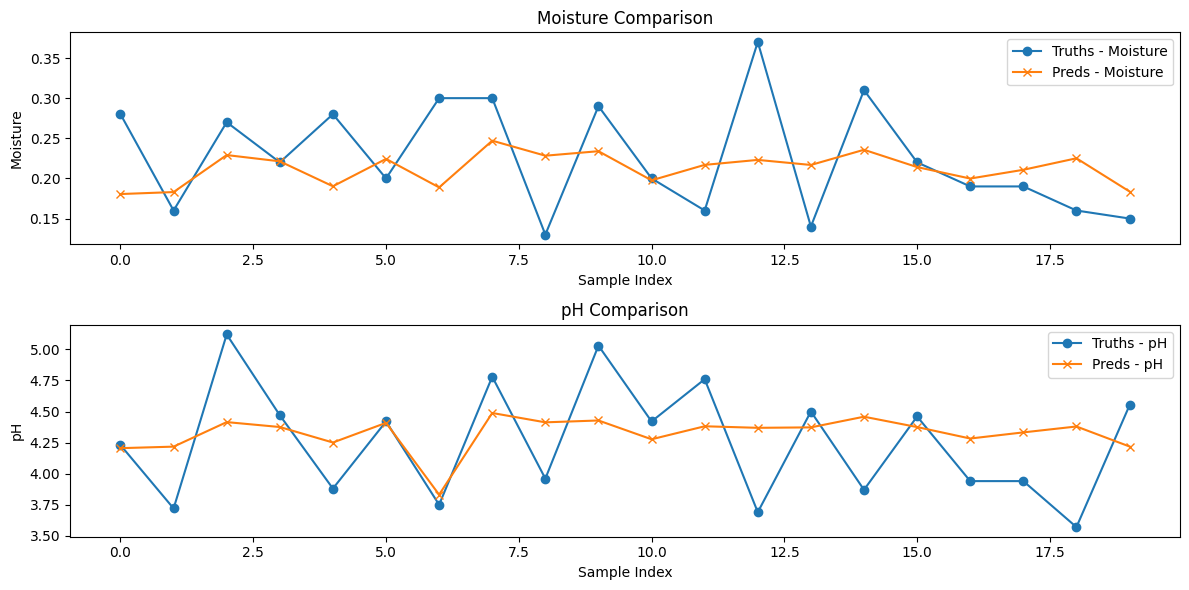

In [216]:

truths = []
preds = []
for i in range(SET*4):
    predictions = modelA.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions[0]))
# Separate moisture and pH values for plotting
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# Plotting the results
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()




In [217]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))

75.16509333634137
91.52613651562267


In [178]:
# def get_accuracy(truths, predictions):
#     true_moisture = unprocess_label(truths,MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
#     predicted_moisture = unprocess_label(predictions,MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)[0]
#     # print(true_moisture,predicted_moisture)
#     accuracy_moisture = (1 - abs(true_moisture - predicted_moisture) / true_moisture) * 100
#     # accuracy_ph = (1 - abs(true_ph - predicted_ph) / true_ph) * 100
#     return accuracy_moisture

# def get_model_accuracy(model, x_values, y_values, copy=[]):
#     predictions = model.predict(x_values)
#     samples = []
#     for i in copy:
#         samples.extend(i)
#     total_acc = []
#     for i,pred in enumerate(predictions):
#         unnormalized = np.array(samples[i]*255)
#         MASK = np.array(get_mask(unnormalized))
#         mask_truth = mask_labels(MASK, np.array(y_values[i]))
#         mask_predictions = mask_labels(MASK, np.array(predictions[i]))
#         total_acc.append(get_accuracy(mask_truth, mask_predictions))
#     return np.mean(total_acc[0])

In [179]:
# truths = []
# preds = []
# for i in range(4*SET):
#     predictions = modelA.predict(np.array([SAMPLE[i]]))
#     truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i], False))
#     preds.append(unprocess_label_wmask(SAMPLE[i],predictions[0], False))

# # Separate moisture and pH values for plotting
# truths_moisture = [truth[0] for truth in truths]
# # truths_ph = [truth[1] for truth in truths]
# preds_moisture = [pred[0] for pred in preds]
# # preds_ph = [pred[1] for pred in preds]


# for i in range(len(truths_moisture)):
#     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
#     # print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# # Plotting the results
# plt.figure(figsize=(12, 6))

# # Moisture Plot
# plt.subplot(2, 1, 1)
# plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
# plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
# plt.title('Moisture Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('Moisture')
# plt.legend()

# # pH Plot
# plt.subplot(2, 1, 2)
# plt.plot(truths_ph, label='Truths - pH', marker='o')
# plt.plot(preds_ph, label='Preds - pH', marker='x')
# plt.title('pH Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('pH')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [180]:
# def accuracy(truth, pred):
#     return (1 - abs(truth - pred) / truth) * 100

# TEMP = []
# for i in range(len(truths_moisture)):
#     TEMP.append(accuracy(truths_moisture[i],preds_moisture[i]))
# print(np.mean(np.array(TEMP)))

In [181]:
# ## Prepare set of x values and y values
# X_values_1,y_values_1 = [],[]
# for i in range(40):
#     values = next(train_generator)
#     X_values_1.append(values[0]) 
#     y_values_1.append(values[1])

# ## create X_values generator
# gen_X_values_1_1 = (x for x in X_values_1)
# gen_X_values_2_1 = (x for x in X_values_1)
# gen_X_values_3_1 = (x for x in X_values_1)
# y_values_1 = [y  for y_set in y_values_1 for y in y_set]

# ## Prepare set of x values and y values
# X_values_2,y_values_2 = [],[]
# for i in range(10):
#     values = next(val_generator)
#     X_values_2.append(values[0])
#     y_values_2.append(values[1])

# ## create X_values generator
# gen_X_values_1_2 = (x for x in X_values_2)
# gen_X_values_2_2 = (x for x in X_values_2)
# gen_X_values_3_2 = (x for x in X_values_2)
# y_values_2 = [y  for y_set in y_values_2 for y in y_set]



In [182]:
# modelA_train_accuracy = get_model_accuracy(modelA, gen_X_values_1_1, y_values_1, X_values_1)
# print("Train Accuracy")
# print("Moisture: {:.2f}, pH: {:.2f}".format(modelA_train_accuracy[0], modelA_train_accuracy[1]))

# modelA_test_accuracy = get_model_accuracy(modelA, gen_X_values_1_2, y_values_2, X_values_2)
# print("Test Accuracy")
# print("Moisture: {:.2f}, pH: {:.2f}".format(modelA_test_accuracy[0], modelA_test_accuracy[1]))

# modelA_train_accuracy = get_model_accuracy(modelA, gen_X_values_1_1, y_values_1, X_values_1)
# print("Train Accuracy")
# print("Moisture: {:.2f}".format(modelA_train_accuracy))

# modelA_test_accuracy = get_model_accuracy(modelA, gen_X_values_1_2, y_values_2, X_values_2)
# print("Test Accuracy")
# print("Moisture: {:.2f}".format(modelA_test_accuracy))


NameError: name 'historyA' is not defined

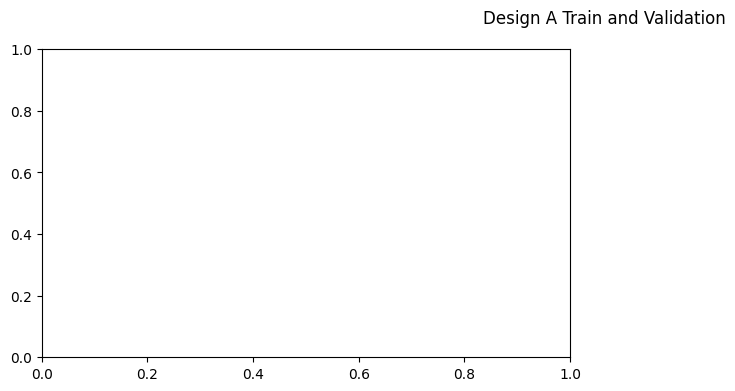

In [ ]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.suptitle("Design A Train and Validation")

plt.subplot(121)
plt.plot(historyA.history['mae'], color ='r')
plt.plot(historyA.history['val_mae'])
plt.title('mae')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mae')

plt.subplot(122)
plt.plot(historyA.history['loss'], color ='r')
plt.plot(historyA.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

In [ ]:
## Design A
train_loss = historyA.history['loss']
train_mae = historyA.history['mae']
val_loss = historyA.history['val_loss']
val_mae = historyA.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train mae: {:.4f}".format(train_mae[best_epoch]))
print("Final Test mae: {:.4f}".format(val_mae[best_epoch]))


Best Epoch:  37
Final Train Loss: 0.0253
Final Validation Loss: 0.0242
Final Train mae: 0.0955
Final Test mae: 0.0935


In [ ]:
# modelA.fit(train_generator, validation_data=val_generator, epochs=100)

In [ ]:
# '''
#    Manual Training with y data alteration
# '''
# ## Variable declaration
# epochs = 512
# steps_per_epoch = 512 // batch_size + 1
# min_lr = 1e-8
# factor = 0.1
# SCHEDULE_EPOCH = 50
# STEPS = 50
# MONITOR = "loss"
# PATIENCE = 10
# WEIGHTS = []

# historyA = {"history": {"loss": [], "mae": [], "val_loss": [], "val_mae": []}}
# for e in range(epochs):
#     for i, (images, y_batch) in enumerate(train_generator):
#         new_y_batch = []

#         ## Train data y alteration
#         for x, img in enumerate(images):
#             array = np.ones(image_size + (3,))
#             array *= img > 0
#             array[array > 0] = y_batch[x]
#             new_y_batch.append(array)
#         new_y_batch = np.array(new_y_batch)
#         loss = modelA.train_on_batch(images, new_y_batch)  # train model for a single iteration

#         if i >= steps_per_epoch:  # manually detect the end of the epoch train set
#             historyA["history"]["loss"].append(loss[0])
#             historyA["history"]["mae"].append(loss[1])
#             break

#     for i, (images, y_batch) in enumerate(val_generator):
#         new_y_batch = []

#         ## Val data y alteration
#         for x, img in enumerate(images):
#             array = np.ones(image_size + (3,))
#             array *= img > 0
#             array[array > 0] = y_batch[x]
#             new_y_batch.append(array)
#         new_y_batch = np.array(new_y_batch)
#         val = modelA.test_on_batch(images, new_y_batch)

#         if i >= steps_per_epoch:  # manually detect the end of the epoch validation set
#             historyA["history"]["val_loss"].append(val[0])
#             historyA["history"]["val_mae"].append(val[1])
#             break
        
#     ## LR Scheduler
#     curr_lr = modelA.optimizer.learning_rate
#     if e >= SCHEDULE_EPOCH and curr_lr > min_lr:
#         K.set_value(modelA.optimizer.learning_rate, curr_lr * factor)
#         curr_lr = modelA.optimizer.learning_rate
#         SCHEDULE_EPOCH += STEPS

#     # ## Early Stopping
#     # if e > PATIENCE:
#     #     PAST = historyA["history"][MONITOR][-PATIENCE-1:-1]
#     #     LATEST = historyA["history"][MONITOR][-1]
#     #     for i,P in enumerate(PAST):
#     #         if LATEST > P:
#     #             PATIENCE -= 1  ## decrement patience if previous monitor is worse than the current value

#     # if PATIENCE <= 0:
#     #     break  ## if no more patience left, early stop training
#     # PATIENCE = 10


#     print("EPOCH: {} LOSS: {:.6f} MAE: {:.6f} VAL_LOSS: {:.6f} VAL_MAE: {:.6f}   CURR_LR {:.2E}".format(
#         e + 1, loss[0], loss[1], val[0], val[1], curr_lr.numpy()))
#     train_generator.on_epoch_end()  # shuffles the data at the end of each epoch


In [ ]:
# plt.figure(figsize=(10,4))

# plt.subplot(121)
# plt.plot(historyA["history"]["loss"], color='g',alpha=.5)
# plt.plot(historyA["history"]["val_loss"], color='r',alpha=.7)
# plt.legend(["Train","Val"])
# plt.ylabel("MSE")
# plt.xlabel("Epochs")

# plt.subplot(122)
# plt.plot(historyA["history"]["mae"], color='g',alpha=.5)
# plt.plot(historyA["history"]["val_mae"], color='r',alpha=.7)
# plt.legend(["Train","Val"])
# plt.ylabel("MAE")
# plt.xlabel("Epochs")

# plt.suptitle("Model A: Nested U-Net")
# plt.show()

In [ ]:
# sample = next(train_generator)


In [ ]:
# print(modelA(sample[0]))
# print(sample[1])

In [ ]:
# # Validation
# val_sample = next(val_generator)
# val_result = modelA.predict(val_sample[0])

# for x, i in enumerate(val_result):
#     RGB = cv2.cvtColor(val_sample[0][x], cv2.COLOR_HSV2RGB)
#     MASK = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY) > 0
#     ARRAY = np.array(val_result[x]).reshape(image_size) * MASK
#     OUTPUT = np.array([x for x in ARRAY.flatten() if x > 0])
#     print("Validation - Average Output:", np.average(OUTPUT), "Ground Truth:", np.average(val_sample[1][x]))


In [ ]:
# modelC.save('design_models/designA.h5')

In [ ]:
# modelA = tf.keras.models.load_model('design_models/designA.h5')

In [ ]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [ ]:
# modelA.save('design_models/designA_v6.h5')


### Design B

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, Dropout, Flatten, Dense, Reshape
# from tensorflow.keras import backend as K
# import tensorflow as tf
# import keras_tuner as kt

# def segnet(hp):
#     hp_filters = hp.Choice('filters', values=[16, 32, 64])
    
#     # Encoding path
#     inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
#     # Encoder
#     x = Conv2D(hp_filters, (3, 3), padding='same', name='conv1')(inputs)
#     x = BatchNormalization(name='bn1')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(hp_filters, (3, 3), padding='same', name='conv2')(x)
#     x = BatchNormalization(name='bn2')(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(name='pool1')(x)
    
#     x = Conv2D(hp_filters * 2, (3, 3), padding='same', name='conv3')(x)
#     x = BatchNormalization(name='bn3')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(hp_filters * 2, (3, 3), padding='same', name='conv4')(x)
#     x = BatchNormalization(name='bn4')(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(name='pool2')(x)
    
#     x = Conv2D(hp_filters * 4, (3, 3), padding='same', name='conv5')(x)
#     x = BatchNormalization(name='bn5')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(hp_filters * 4, (3, 3), padding='same', name='conv6')(x)
#     x = BatchNormalization(name='bn6')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(hp_filters * 4, (3, 3), padding='same', name='conv7')(x)
#     x = BatchNormalization(name='bn7')(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(name='pool3')(x)
    
#     x = Conv2D(hp_filters * 8, (3, 3), padding='same', name='conv8')(x)
#     x = BatchNormalization(name='bn8')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(hp_filters * 8, (3, 3), padding='same', name='conv9')(x)
#     x = BatchNormalization(name='bn9')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(hp_filters * 8, (3, 3), padding='same', name='conv10')(x)
#     x = BatchNormalization(name='bn10')(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(name='pool4')(x)
    
#     x = Conv2D(hp_filters * 8, (3, 3), padding='same', name='conv11')(x)
#     x = BatchNormalization(name='bn11')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(hp_filters * 8, (3, 3), padding='same', name='conv12')(x)
#     x = BatchNormalization(name='bn12')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(hp_filters * 8, (3, 3), padding='same', name='conv13')(x)
#     x = BatchNormalization(name='bn13')(x)
#     x = Activation('relu')(x)
#     qwe = MaxPooling2D(name='pool5')(x)
#     print(x.shape)
#     x = Flatten()(x);UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256);DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    
#     BATCHNORM = hp.Boolean('batchnorm',default=False)
#     # Dense layers between encoder and decoder
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     # Reshape back to spatial dimensions for the decoder
#     SIZE = IMAGE_SIZE[0] // 16  # Assuming input size is a multiple of 32
#     if BATCHNORM:
#         x = BatchNormalization()(x)
#     x = Dense(SIZE * SIZE * 512, activation='relu')(x)
#     print((SIZE, SIZE, 512))
#     x = Reshape((SIZE, SIZE, 512))(x)
    
#     # Decoding path
#     x = UpSampling2D()(x)
#     x = Conv2DTranspose(hp_filters * 8, (3, 3), padding='same', name='deconv1')(x)
#     x = BatchNormalization(name='bn14')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(hp_filters * 8, (3, 3), padding='same', name='deconv2')(x)
#     x = BatchNormalization(name='bn15')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(hp_filters * 8, (3, 3), padding='same', name='deconv3')(x)
#     x = BatchNormalization(name='bn16')(x)
#     x = Activation('relu')(x)
    
#     x = UpSampling2D()(x)
#     x = Conv2DTranspose(hp_filters * 4, (3, 3), padding='same', name='deconv4')(x)
#     x = BatchNormalization(name='bn17')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(hp_filters * 4, (3, 3), padding='same', name='deconv5')(x)
#     x = BatchNormalization(name='bn18')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(hp_filters * 4, (3, 3), padding='same', name='deconv6')(x)
#     x = BatchNormalization(name='bn19')(x)
#     x = Activation('relu')(x)
    
#     x = UpSampling2D()(x)
#     x = Conv2DTranspose(hp_filters * 2, (3, 3), padding='same', name='deconv7')(x)
#     x = BatchNormalization(name='bn20')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(hp_filters * 2, (3, 3), padding='same', name='deconv8')(x)
#     x = BatchNormalization(name='bn21')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(hp_filters, (3, 3), padding='same', name='deconv9')(x)
#     x = BatchNormalization(name='bn22')(x)
#     x = Activation('relu')(x)
    
#     x = UpSampling2D()(x)
#     x = Conv2DTranspose(hp_filters, (3, 3), padding='same', name='deconv10')(x)
#     x = BatchNormalization(name='bn23')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(hp_filters, (3, 3), padding='same', name='deconv11')(x)
#     x = BatchNormalization(name='bn24')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv12')(x)
#     x = BatchNormalization(name='bn25')(x)
#     x = Activation('relu')(x)
    
#     x = UpSampling2D()(x)
#     x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
#     x = BatchNormalization(name='bn26')(x)
    
#     # Output layer with sigmoid activation for binary segmentation
#     outputs = Conv2D(2, (1, 1), strides=2, activation='sigmoid')(x)
#     print(outputs.shape)
    
#     model = Model(inputs=inputs, outputs=outputs);lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]);model.compile(optimizer= tf.keras.optimizers.Adam(lr=lr), loss= ["binary_crossentropy"], metrics=['acc'])

#     return model

In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Concatenate
# from tensorflow.keras.models import Model

# def segnet(hp, input_shape=(64, 64, 3), num_classes=2):
#     # Load ResNet50 with pre-trained weights and without top layers
#     resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

#     # Get encoder output layers
#     encoder_outputs = [
#         resnet_base.get_layer("conv1_relu").output,
#         resnet_base.get_layer("conv2_block3_out").output,
#         resnet_base.get_layer("conv3_block4_out").output,
#         resnet_base.get_layer("conv4_block6_out").output,
#         resnet_base.get_layer("conv5_block3_out").output
#     ]

#     # Decoder part of SegNet
#     x = encoder_outputs[-1]
#     for i in range(4, 0, -1):
#         x = UpSampling2D()(x)
#         x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#         x = BatchNormalization()(x)
#         x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#         x = BatchNormalization()(x)
#         x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#         x = BatchNormalization()(x)
#         x = Concatenate()([x, encoder_outputs[i - 1]])

#     x = UpSampling2D()(x)
#     # Output layer
#     outputs = Conv2D(2, (1, 1), activation='softmax')(x)
#     print(outputs.shape)
#     # Create model
#     model = Model(inputs=resnet_base.input, outputs=outputs)
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]);model.compile(optimizer= tf.keras.optimizers.Adam(lr=lr), loss= ["binary_crossentropy"], metrics=['acc'])
#     return model

# # Usage
# # model = segnet_with_resnet50()


In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, Dropout, Flatten, Dense, Reshape
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras import backend as K
# import tensorflow as tf
# import keras_tuner as kt

# def segnet(hp):
#     hp_filters = hp.Choice('filters', values=[16, 32, 64])
    
#     # Load ResNet50 with pre-trained weights
#     resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(64,64,3))
#     resnet_base.trainable = False

#     # Encoder part using ResNet50
#     inputs = Input(shape=(64,64,3))
#     encoder_outputs = [
#         resnet_base.get_layer("conv1_relu").output,
#         resnet_base.get_layer("conv2_block3_out").output,
#         resnet_base.get_layer("conv3_block4_out").output,
#         resnet_base.get_layer("conv4_block6_out").output,
#         resnet_base.get_layer("conv5_block3_out").output
#     ]

#     # Flatten the bottleneck output
#     x = Flatten()(encoder_outputs[-1])

#     # Dense layers between encoder and decoder
#     x = Dense(2048, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(2048, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(2048, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(2048, activation='relu')(x)
    
#     print(encoder_outputs[-1].shape)
    
#     # Reshape back to spatial dimensions for the decoder
#     SIZE = 2
    
#     x = Dense(SIZE * SIZE * 2048, activation='relu')(x)
#     x = Reshape((SIZE, SIZE, 2048))(x)
    
#     # Decoder part
#     for i in range(4, 0, -1):
#         x = UpSampling2D()(x)
#         x = Conv2D(hp_filters * 8, (3, 3), padding='same')(x)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)
#         x = Conv2D(hp_filters * 8, (3, 3), padding='same')(x)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)
#         x = Conv2D(hp_filters * 8, (3, 3), padding='same')(x)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)
#         x = Concatenate()([x, encoder_outputs[i - 1]])

#     # Output layer
#     outputs = Conv2D(2, (1, 1), activation='sigmoid')(x)

#     # Create and compile model
#     model = Model(inputs=inputs, outputs=outputs)
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss="binary_crossentropy", metrics=['acc'])

#     return model


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import cv2
import numpy as np

class MaskAndBitwiseAndLayer(Layer):
    def __init__(self, **kwargs):
        super(MaskAndBitwiseAndLayer, self).__init__(**kwargs)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        outputs = []

        for i in range(batch_size):
            img = inputs[i]

            # Multiply the image by 255
            img = img * 255

            # Convert to numpy array
            img_np = img.numpy().astype(np.uint8)

            # Get the mask (Assuming thresholding for mask)
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            _, binr = cv2.threshold(gray, 32, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            binr = np.invert(binr)

            kernel = np.ones((3, 3), np.uint8)
            mask = cv2.erode(binr, kernel, iterations=3)

            # Apply bitwise AND
            masked_img = cv2.bitwise_and(img_np, img_np, mask=mask)

            # Convert back to tensor
            masked_img = tf.convert_to_tensor(masked_img, dtype=tf.float32)
            outputs.append(masked_img)

        return tf.stack(outputs)

    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
# import tensorflow as tf

# def masked_mse_loss(y_true, y_pred):
#     # Create a binary mask where non-zero values in y_true are set to 1
#     mask = tf.cast(tf.greater(y_true, 0.0), tf.float32)
    
#     # Apply the mask to both y_true and y_pred
#     y_true_masked = tf.multiply(y_true, mask)
#     y_pred_masked = tf.multiply(y_pred, mask)
    
#     # Calculate the squared differences
#     squared_difference = tf.square(y_true_masked - y_pred_masked)
    
#     # Compute the mean squared error, considering only masked areas
#     masked_mse = tf.reduce_sum(squared_difference) / tf.reduce_sum(mask)
    
#     return masked_mse


In [ ]:
# from keras.src import ops
# from keras.src.losses.loss import squeeze_or_expand_to_same_rank

# @tf.autograph.experimental.do_not_convert
# def masked_mean_squared_error(y_true, y_pred):
#     """Computes the mean squared error between labels and predictions with mask.

#     Formula:

#     ```python
#     loss = mean(square(y_true - y_pred), axis=-1)
#     ```

#     Example:

#     >>> y_true = np.random.randint(0, 2, size=(2, 3))
#     >>> y_pred = np.random.random(size=(2, 3))
#     >>> loss = keras.losses.mean_squared_error(y_true, y_pred)

#     Args:
#         y_true: Ground truth values with shape = `[batch_size, d0, .. dN]`.
#         y_pred: The predicted values with shape = `[batch_size, d0, .. dN]`.

#     Returns:
#         Mean squared error values with shape = `[batch_size, d0, .. dN-1]`.
#     """
    
#     mask = tf.cast(tf.greater(y_true, 0.0), tf.float32)
    
#     y_pred_masked = tf.multiply(y_pred, mask)
    
#     y_pred_final = ops.convert_to_tensor(y_pred_masked)
    
#     y_true = ops.convert_to_tensor(y_true, dtype=y_pred_final.dtype)
    
#     y_true, y_pred_final = squeeze_or_expand_to_same_rank(y_true, y_pred_final)
    
#     return ops.mean(ops.square(y_true - y_pred_final), axis=-1)


In [ ]:
# def get_mask(image):
#     image = image.astype(np.uint8)
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#     binr = cv2.threshold(gray, 32, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#     binr = np.invert(binr)

#     kernel = np.ones((3, 3), np.uint8)
#     mask = cv2.erode(binr, kernel, iterations=3)
    
#     return mask

# def process_image(image):
#     rgb_image = image.astype(np.uint8)
    
#     mask = get_mask(image)

#     rgb_planes = cv2.split(rgb_image)
#     result_planes = []
#     for plane in rgb_planes:
#         processed_image = cv2.medianBlur(plane, 3)
#         processed_image = cv2.bitwise_and(processed_image, processed_image, mask=mask)
#         result_planes.append(processed_image)
#     result = cv2.merge(result_planes)

#     return result

# def process_label(image, label, maxPh, minPh, maxMoisture, minMoisture):
#     mask = get_mask(np.array(image))
#     shape = mask.shape 
#     array = np.ones(shape=(shape[0], shape[1], 1))

#     moisture = cv2.bitwise_and(array, array, mask=mask)
#     ph = cv2.bitwise_and(array, array, mask=mask)

#     # moisture_value = (label[0] - minMoisture) / (maxMoisture - minMoisture)
#     # ph_value = (label[1] - minPh) / (maxPh - minPh)
#     moisture[moisture > 0] = label[0]#moisture_value
#     ph[ph > 0] = label[1]#ph_value

#     # output = [moisture, ph]#np.stack([moisture, ph], axis=-1)  
#     output = np.stack([moisture, ph], axis=-1)  

#     return output

In [313]:


# import tensorflow as tf
# from tensorflow.keras import layers, Model
# from tensorflow.keras.applications import VGG16

def segnet(hp, input_shape=(64, 64, 3), num_classes=2):
    # Load the VGG16 model with batch normalization
    vgg16_bn = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg16_bn.trainable = True
    
    ## DITO KO LALAGAY
    
    # Encoder
    inputs = layers.Input(shape=input_shape)

    # Using the pretrained VGG16_bn layers
    x = vgg16_bn.get_layer('block1_conv1')(inputs)
    x = vgg16_bn.get_layer('block1_conv2')(x)
    stage1 = x
    x = vgg16_bn.get_layer('block1_pool')(x)

    x = vgg16_bn.get_layer('block2_conv1')(x)
    x = vgg16_bn.get_layer('block2_conv2')(x)
    stage2 = x
    x = vgg16_bn.get_layer('block2_pool')(x)

    x = vgg16_bn.get_layer('block3_conv1')(x)
    x = vgg16_bn.get_layer('block3_conv2')(x)
    x = vgg16_bn.get_layer('block3_conv3')(x)
    stage3 = x
    x = vgg16_bn.get_layer('block3_pool')(x)

    x = vgg16_bn.get_layer('block4_conv1')(x)
    x = vgg16_bn.get_layer('block4_conv2')(x)
    x = vgg16_bn.get_layer('block4_conv3')(x)
    stage4 = x
    x = vgg16_bn.get_layer('block4_pool')(x)

    x = vgg16_bn.get_layer('block5_conv1')(x)
    x = vgg16_bn.get_layer('block5_conv2')(x)
    x = vgg16_bn.get_layer('block5_conv3')(x)
    stage5 = x
    x = vgg16_bn.get_layer('block5_pool')(x)

    UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256)
    DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm',default=False)
    
    # Dense layers between encoder and decoder
    x = layers.Flatten()(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    if BATCHNORM:
        x = BatchNormalization()(x)
    SIZE = input_shape[0]//32
    x = layers.Dense(SIZE*SIZE*512, activation='relu')(x)  # Adjust to match the new dimensions
    x = layers.Reshape((SIZE, SIZE, 512))(x)  # Adjust to match the new dimensions

    # Decoder
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage5
    x = layers.Concatenate()([x, stage5])
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage4
    x = layers.Concatenate()([x, stage4])
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage3
    x = layers.Concatenate()([x, stage3])
    x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage2
    x = layers.Concatenate()([x, stage2])
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage1
    x = layers.Concatenate()([x, stage1])
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(num_classes, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='SegNet')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mae'])
    return model



In [319]:
tunerB = kt.BayesianOptimization(segnet,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_b',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)


tunerB.search(train_generator, epochs=30, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsB=tunerB.get_best_hyperparameters(num_trials=1)[0]



print(best_hpsB.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_b\tuner0.json
{'units': 1024, 'dropout': 0.2, 'batchnorm': False, 'optimizer': 'rmsprop', 'learning_rate': 0.0001}


In [320]:
# best_hpsB.values['learning_rate']=1e-3

In [321]:
# Build the model with the best hp.
modelB = segnet(best_hpsB)
modelB.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_17[0][0]']               
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[1][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[1][0]']           
                                                                                             

In [322]:
# # Define the optimizer
# optimizer = tf.keras.optimizers.Adam()

# # Define the training dataset
# train_dataset = tf.data.Dataset.from_generator(
#     train_generator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([batch_size, 256, 256, 3], [batch_size, 256, 256, 1])
# ).repeat().prefetch(tf.data.experimental.AUTOTUNE)

# # Define the validation dataset
# val_dataset = tf.data.Dataset.from_generator(
#     val_generator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([batch_size, 256, 256, 3], [batch_size, 256, 256, 1])
# ).repeat().prefetch(tf.data.experimental.AUTOTUNE)

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch + 1}/{num_epochs}")
    
#     # Training loop
#     for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
#         with tf.GradientTape() as tape:
#             logits = model(x_batch_train, training=True)
#             loss_value = masked_mse_loss(y_batch_train, logits)
        
#         grads = tape.gradient(loss_value, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         print(f"Step {step}, Loss: {loss_value.numpy()}")
        
#     # Validation loop
#     val_losses = []
#     for x_batch_val, y_batch_val in val_dataset:
#         val_logits = model(x_batch_val, training=False)
#         val_loss = masked_mse_loss(y_batch_val, val_logits)
#         val_losses.append(val_loss)
    
#     avg_val_loss = tf.reduce_mean(val_losses)
#     print(f"Validation Loss: {avg_val_loss.numpy()}")

In [323]:
## DESIGN B
import time 
start = time.time()
historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024


178/178 - 19s - loss: 4.9630 - mae: 1.3644 - val_loss: 5.1893 - val_mae: 1.4993 - lr: 1.0000e-04 - 19s/epoch - 105ms/step
Epoch 2/1024
178/178 - 13s - loss: 4.8293 - mae: 1.3095 - val_loss: 5.1461 - val_mae: 1.3215 - lr: 1.0000e-04 - 13s/epoch - 74ms/step
Epoch 3/1024
178/178 - 13s - loss: 4.7118 - mae: 1.2715 - val_loss: 4.9159 - val_mae: 1.3559 - lr: 1.0000e-04 - 13s/epoch - 74ms/step
Epoch 4/1024
178/178 - 13s - loss: 4.5953 - mae: 1.2475 - val_loss: 4.8204 - val_mae: 1.3433 - lr: 1.0000e-04 - 13s/epoch - 72ms/step
Epoch 5/1024
178/178 - 13s - loss: 4.4734 - mae: 1.2258 - val_loss: 4.6593 - val_mae: 1.2809 - lr: 1.0000e-04 - 13s/epoch - 71ms/step
Epoch 6/1024
178/178 - 13s - loss: 4.3531 - mae: 1.2043 - val_loss: 4.5164 - val_mae: 1.3096 - lr: 1.0000e-04 - 13s/epoch - 71ms/step
Epoch 7/1024
178/178 - 13s - loss: 4.2373 - mae: 1.1978 - val_loss: 4.4575 - val_mae: 1.2211 - lr: 1.0000e-04 - 13s/epoch - 71ms/step
Epoch 8/1024
178/178 - 13s - loss: 4.1203 - mae: 1.1804 - val_loss: 4.3216

In [324]:
import matplotlib.pyplot as plt

In [335]:
NUM=3

predictions = modelB.predict(np.array([SAMPLE[NUM]]))
truth = unprocess_label_wmask(SAMPLE[NUM],SAMPLE_Y[NUM])
pred = unprocess_label_wmask(SAMPLE[NUM],predictions[0])
print("TRUTH moisture: {:.2f}, ph: {:.2f}".format(truth[0],truth[1]))
print("PREDICTIONS moisture: {:.2f}, ph: {:.2f}".format(pred[0],pred[1]))

1/1 [==============================] - 0s 18ms/step
TRUTH moisture: 0.27, ph: 4.80
PREDICTIONS moisture: 0.28, ph: 4.52


In [336]:
len(SAMPLE)

20

1/1 [==============================] - 0s 19ms/step
Moisture Truth : 0.22 Pred: 0.27
ph   Truth: 5.28 Pred: 4.47

Moisture Truth : 0.23 Pred: 0.23
ph   Truth: 4.68 Pred: 4.15

Moisture Truth : 0.16 Pred: 0.22
ph   Truth: 3.57 Pred: 4.18

Moisture Truth : 0.30 Pred: 0.23
ph   Truth: 4.84 Pred: 4.21

Moisture Truth : 0.20 Pred: 0.25
ph   Truth: 3.98 Pred: 4.22

Moisture Truth : 0.19 Pred: 0.24
ph   Truth: 3.94 Pred: 4.22

Moisture Truth : 0.33 Pred: 0.19
ph   Truth: 4.35 Pred: 3.98

Moisture Truth : 0.19 Pred: 0.21
ph   Truth: 4.37 Pred: 4.05

Moisture Truth : 0.21 Pred: 0.22
ph   Truth: 4.64 Pred: 4.13

Moisture Truth : 0.13 Pred: 0.21
ph   Truth: 4.41 Pred: 4.13

Moisture Truth : 0.19 Pred: 0.15
ph   Truth: 4.37 Pred: 3.91

Moisture Truth : 0.23 Pred: 0.23
ph   Truth: 4.68 Pred: 4.15

Moisture Truth : 0.19 Pred: 0.15
ph   Truth: 4.37 Pred: 3.91

Moisture Truth : 0.12 Pred: 0.21
ph   Truth: 4.31 Pred: 4.09

Moisture Truth : 0.26 Pred: 0.24
ph   Truth: 4.43 Pred: 4.17

Moisture Truth : 0

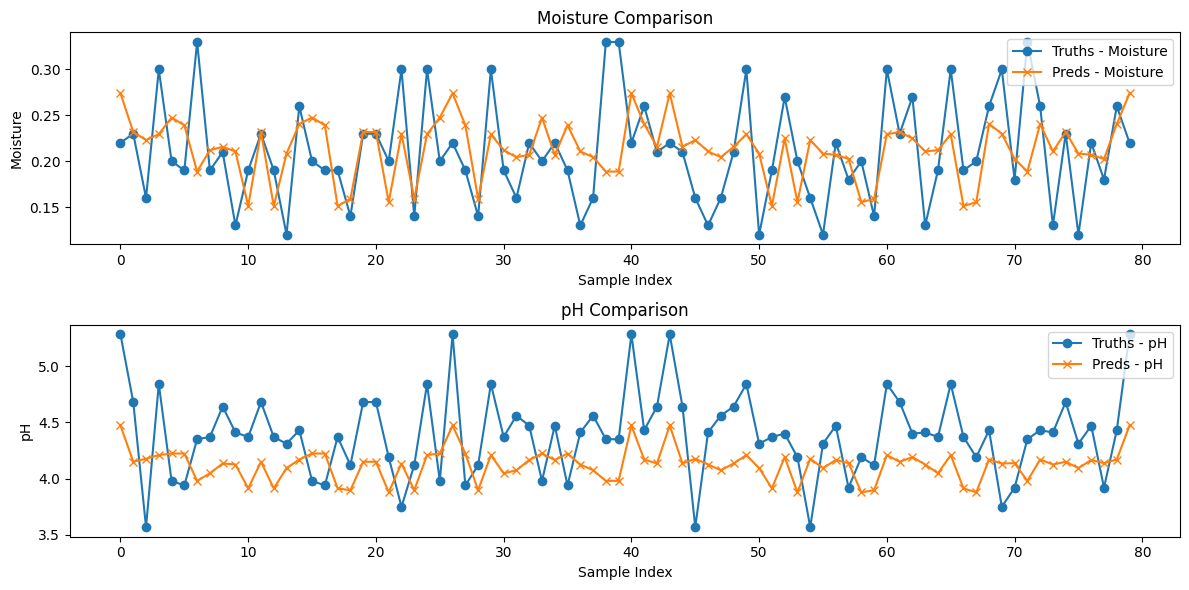

In [341]:
truths = []
preds = []
for i in range(SET*4):
    predictions = modelB.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions[0]))
# Separate moisture and pH values for plotting
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# Plotting the results
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()

In [342]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))


76.06080467636559
91.02962013690701


In [231]:
# them=4

In [232]:
# unprocess_label_wmask(SAMPLE[them],SAMPLE_Y[them], False)

In [233]:
# for i in unprocess_label_wmask(SAMPLE[them]*255,SAMPLE_Y[them], False):
#     print(i)

In [234]:
# for i in unprocess_label_wmask(SAMPLE[them]*255,modelB.predict(np.array([SAMPLE[them]]))[0], False):
#     print(i)

In [235]:
0.33358812 * (float(MAXMOISTURE) - float(MINMOISTURE)) + float(MINMOISTURE)

0.20007643600000002

In [236]:
0.37058967 * (float(MAXPH) - float(MINPH)) + float(MINPH)

4.3304736872

In [237]:
# plt.imshow(np.array(SAMPLE[0][0]*255).astype(np.uint8))

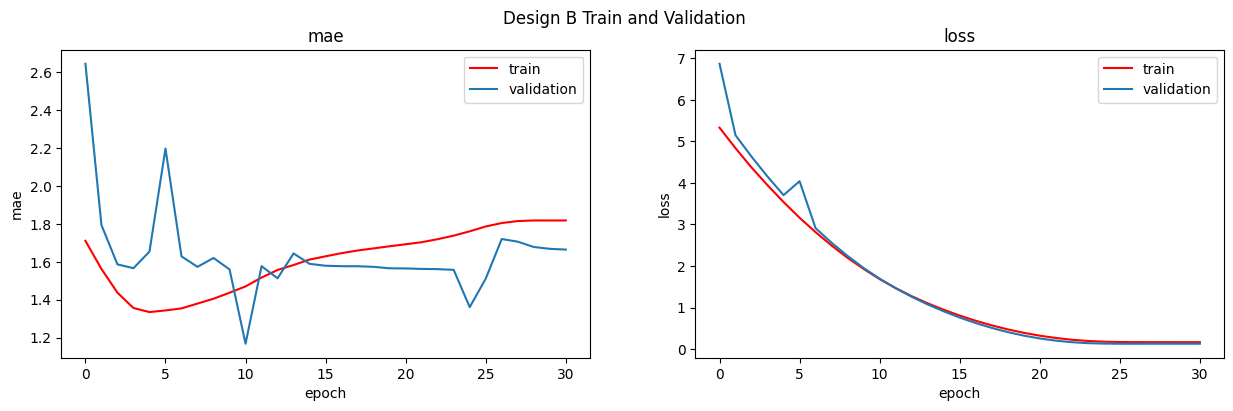

In [238]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.suptitle("Design B Train and Validation")

plt.subplot(121)
plt.plot(historyB.history['mae'], color ='r')
plt.plot(historyB.history['val_mae'])
plt.title('mae')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mae')

plt.subplot(122)
plt.plot(historyB.history['loss'], color ='r')
plt.plot(historyB.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

In [239]:
## Design B
train_loss = historyB.history['loss']
train_mae = historyB.history['mae']
val_loss = historyB.history['val_loss']
val_mae = historyB.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train mae: {:.4f}".format(train_mae[best_epoch]))
print("Final Test mae: {:.4f}".format(val_mae[best_epoch]))


Best Epoch:  25
Final Train Loss: 0.1694
Final Validation Loss: 0.1280
Final Train mae: 1.7865
Final Test mae: 1.5109


In [89]:
# epochs = 512
# steps_per_epoch = 512 // batch_size + 1  # we usually consider 1 epoch to be
#                                             # the point where the model has seen
#                                             # all the training samples at least once
# min_lr = 1e-8
# factor = 0.1
# SCHEDULE_EPOCH = 200
# STEPS = 200


# historyB = {"history":{"loss":[],"mae":[],"val_loss":[],"val_mae":[]}}
# for e in range(epochs):
#     for i, (images, y_batch) in enumerate(train_generator):
#        new_y_batch = []
#        for x,img in enumerate(images):
#         array = np.ones(image_size+(3,))
#         array *= img>0
#         array[array>0] = y_batch[x]
#         new_y_batch.append(array)
#        new_y_batch = np.array(new_y_batch)
#        loss = modelB.train_on_batch(images, new_y_batch)  # train model for a single iteration
#     #    val = modelB.test_on_batch(images, new_y_batch)
#        if i >= steps_per_epoch:  # manually detect the end of the epoch
#             historyB["history"]["loss"].append(loss[0])
#             historyB["history"]["mae"].append(loss[1])
#             # print("EPOCH: {} LOSS: {:.6f} 2ND_METRIC: {:.6f}".format(e+1, loss[0], loss[1]))
#             break  
#     for i, (images, y_batch) in enumerate(val_generator):
#        new_y_batch = []
#        for x,img in enumerate(images):
#         array = np.ones(image_size+(3,))
#         array *= img>0
#         array[array>0] = y_batch[x]
#         new_y_batch.append(array)
#        new_y_batch = np.array(new_y_batch)
#     #    loss = modelB.train_on_batch(images, new_y_batch)  # train model for a single iteration
#        val = modelB.test_on_batch(images, new_y_batch)
#        if i >= steps_per_epoch:  # manually detect the end of the epoch
#             historyB["history"]["val_loss"].append(val[0])
#             historyB["history"]["val_mae"].append(val[1])
#             # print("EPOCH: {} LOSS: {:.6f} 2ND_METRIC: {:.6f}".format(e+1, loss[0], loss[1]))
#             curr_lr = modelB.optimizer.learning_rate
#             if e>=SCHEDULE_EPOCH and curr_lr>min_lr: 
#                K.set_value(modelB.optimizer.learning_rate, curr_lr*factor)
#                curr_lr = modelB.optimizer.learning_rate
#                SCHEDULE_EPOCH+=STEPS
#             # patience = 2
#             # if e>patience and curr_lr>min_lr:
#                # curr_loss = historyA["history"]["val_loss"][-1]
#                # for i in historyA["history"]["val_loss"][-patience-1:-1]:
#                #    if curr_loss >= i: patience-=1
#                #    if patience < 1:
#                      # K.set_value(modelA.optimizer.learning_rate, curr_lr*factor)
#                      # curr_lr = modelA.optimizer.learning_rate
#             break  
#     print("EPOCH: {} LOSS: {:.6f} MAE: {:.6f} VAL_LOSS: {:.6f} VAL_MAE: {:.6f}   CURR_LR {:.2E}".format(e+1, loss[0], loss[1],val[0],val[1], curr_lr.numpy()))
#     train_generator.on_epoch_end()  # this shuffles the data at the end of each epoch

In [90]:
# plt.figure(figsize=(10,4))

# plt.subplot(121)
# plt.plot(historyB["history"]["loss"][10:], color='g',alpha=.5)
# plt.plot(historyB["history"]["val_loss"][10:], color='r',alpha=.7)
# plt.legend(["Train","Val"])
# plt.ylabel("MSE")
# plt.xlabel("Epochs")

# plt.subplot(122)
# plt.plot(historyB["history"]["mae"][10:], color='g',alpha=.5)
# plt.plot(historyB["history"]["val_mae"][10:], color='r',alpha=.7)
# plt.legend(["Train","Val"])
# plt.ylabel("MAE")
# plt.xlabel("Epochs")

# plt.suptitle("Model B: SegNet")
# plt.show()

In [91]:
# np.array(historyB["history"]["loss"]).shape

In [92]:
# red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1,
#                               patience=10, min_lr=1e-7)
# # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
# history = modelB.fit(train_generator, epochs=2,# validation_data=val_generator,
#                      callbacks=[red_lr])

In [93]:
# sample = next(train_generator)


In [94]:
# sample = next(train_generator)
# result = modelB(sample[0])
# for x,i in enumerate(result):
#     RGB  = cv2.cvtColor(sample[0][x],cv2.COLOR_HSV2RGB)
#     MASK = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY) > 0
#     ARRAY = np.array(result[5]).reshape(image_size) * MASK
#     OUTPUT = np.array([x for x in ARRAY.flatten() if x > 0])
#     print(np.average(OUTPUT), np.average(sample[1][x]))

In [95]:

# plt.imshow(result[5])

In [96]:
# plt.imshow(sample[0][5])

In [97]:
# import cv2
# RGB  = cv2.cvtColor(sample[0][5],cv2.COLOR_HSV2RGB)
# MASK = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY) > 0
# ARRAY = np.array(result[5]).reshape(image_size) * MASK


In [98]:
# AVE = np.average(ARRAY)
# TRUTH = sample[1][5]
# print(AVE)
# print(TRUTH)

In [99]:
# plt.imshow(ARRAY)
# plt.show()

In [100]:
# modelA.save('design_models/BEST/designA_V3.h5')
# modelB.save('design_models/BEST/designB_V3.h5')
# modelC.save('design_models/BEST/designC_V3.h5')

In [101]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [102]:
# modelB.save('design_models/designB_v6.h5')


### Design C

In [240]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, Dropout, Flatten, Dense, Reshape, AveragePooling2D, Concatenate
# from tensorflow.keras import layers, initializers
# import tensorflow as tf
# import keras_tuner as kt

# def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
#     x = Conv2D(
#         num_filters,
#         kernel_size=kernel_size,
#         dilation_rate=dilation_rate,
#         padding=padding,
#         use_bias=use_bias,
#         kernel_initializer=initializers.HeNormal(),
#     )(block_input)
#     x = BatchNormalization()(x)
#     return Activation('relu')(x)

# def DilatedSpatialPyramidPooling(dspp_input, num_filters):
#     dims = dspp_input.shape
#     x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
#     x = convolution_block(x, kernel_size=1, use_bias=True)
#     out_pool = UpSampling2D(
#         size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
#     )(x)

#     out_1 = convolution_block(dspp_input, num_filters=num_filters, kernel_size=1, dilation_rate=1)
#     out_6 = convolution_block(dspp_input, num_filters=num_filters,  kernel_size=3, dilation_rate=6)
#     out_12 = convolution_block(dspp_input, num_filters=num_filters,  kernel_size=3, dilation_rate=12)
#     out_18 = convolution_block(dspp_input, num_filters=num_filters,  kernel_size=3, dilation_rate=18)

#     x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
#     output = convolution_block(x, kernel_size=1)
#     return output

# def DeeplabV3Plus(hp, image_size=(64, 64)):
#     model_input = Input(shape=image_size+(3,))
#     resnet50 = tf.keras.applications.ResNet50(
#         weights='imagenet', include_top=False, input_tensor=model_input
#     )
#     for layer in resnet50.layers:
#         layer.trainable=True
    
#     hp_filters = hp.Choice('filters', values=[16, 32, 64])
#     x = resnet50.get_layer("conv1_relu").output
#     x = DilatedSpatialPyramidPooling(x, hp_filters*2)
#     print(x.shape)
#     x = Flatten()(x)
#     x = Dense(hp_filters*hp_filters, activation='relu')(x)

#     UNITS = hp_filters*hp_filters
#     hp.Boolean("dropouts", default=False)
#     hp.Boolean("batch_normalization", default=False)

#     x = Dense(UNITS, activation='relu')(x)
#     if hp.Boolean("dropouts"):
#         x = Dropout(0.5)(x)
#     if hp.Boolean("batch_normalization"):
#         x = BatchNormalization()(x)
#     x = Dense(UNITS, activation='relu')(x)
#     if hp.Boolean("dropouts"):
#         x = Dropout(0.5)(x)
#     if hp.Boolean("batch_normalization"):
#         x = BatchNormalization()(x)
#     x = Dense(UNITS, activation='relu')(x)
#     if hp.Boolean("4th_dense", default=False):
#         x = Dense(UNITS, activation='relu')(x)
#         if hp.Boolean("dropouts"):
#             x = Dropout(0.5)(x)
#         if hp.Boolean("batch_normalization"):
#             x = BatchNormalization()(x)

#     SIZE = image_size[0]
#     temp = 0
#     if hp_filters == 16:
#         temp = hp_filters
#     if hp_filters == 32:
#         temp = hp_filters * 2
#     if hp_filters == 64:
#         temp = hp_filters * 4
#     x = Reshape((SIZE // 16, SIZE // 16, temp))(x)

#     x = UpSampling2D(size=(SIZE // 4 // x.shape[1], SIZE // 4 // x.shape[2]), interpolation="bilinear")(x)
#     input_b = resnet50.get_layer("conv2_block3_2_relu").output
#     input_b = convolution_block(input_b, num_filters=hp_filters, kernel_size=1)

#     x = Concatenate(axis=-1)([x, input_b])
#     x = convolution_block(x, num_filters=hp_filters*4)
#     x = convolution_block(x, num_filters=hp_filters*4)
#     x = UpSampling2D(size=(SIZE // x.shape[1], SIZE // x.shape[2]), interpolation="bilinear")(x)
    
#     outputs = Conv2D(2, 1, activation='sigmoid')(x)
    
#     model = Model(inputs=model_input, outputs=outputs)
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss=["binary_crossentropy"], metrics=['acc'])

#     return model


In [241]:
# def DeeplabV3Plus(hp, image_size=(32, 32)):
#     model_input = Input(shape=image_size + (3,))
#     resnet50 = tf.keras.applications.ResNet50(
#         weights='imagenet', include_top=False, input_tensor=model_input
#     )
#     for layer in resnet50.layers:
#         layer.trainable = True
    
#     hp_filters = hp.Choice('filters', values=[16, 32, 64])
#     x = resnet50.get_layer("conv1_relu").output
#     x = DilatedSpatialPyramidPooling(x, hp_filters * 2)
#     print(x.shape)
#     x = Flatten()(x)
    
#     UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
#     DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)
#     BATCHNORM = hp.Boolean('batchnorm', default=False)

#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)

#     if hp.Boolean("batch_normalization"):
#         x = BatchNormalization()(x)
#     x = Dense(UNITS, activation='relu')(x)

#     SIZE = image_size[0]
#     temp = 0
#     if hp_filters == 16:
#         temp = hp_filters
#     if hp_filters == 32:
#         temp = hp_filters * 2
#     if hp_filters == 64:
#         temp = hp_filters * 4
#     x = Reshape((SIZE // 16, SIZE // 16, temp))(x)

#     x = UpSampling2D(size=(SIZE // 4 // x.shape[1], SIZE // 4 // x.shape[2]), interpolation="bilinear")(x)
#     input_b = resnet50.get_layer("conv2_block3_2_relu").output
#     input_b = convolution_block(input_b, num_filters=hp_filters, kernel_size=1)

#     x = Concatenate(axis=-1)([x, input_b])
#     x = convolution_block(x, num_filters=hp_filters * 4)
#     x = convolution_block(x, num_filters=hp_filters * 4)
#     x = UpSampling2D(size=(SIZE // x.shape[1], SIZE // x.shape[2]), interpolation="bilinear")(x)
    
#     outputs = Conv2D(2, 1, activation='sigmoid')(x)
    
#     model = Model(inputs=model_input, outputs=outputs)
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss=["binary_crossentropy"], metrics=['acc'])

#     return model


In [242]:
# def DeeplabV3Plus(hp,image_size=(64, 64)):
#     model_input = Input(shape=image_size + (3,))
#     resnet50 = tf.keras.applications.ResNet50(
#         weights='imagenet', include_top=False, input_tensor=model_input
#     )
#     for layer in resnet50.layers:
#         layer.trainable = True
#     hp_filters = hp.Choice('filters', values=[16, 32, 64])
    
#     x = resnet50.get_layer("conv1_relu").output
#     x = resnet50.get_layer("conv2_block3_out").output
#     x = DilatedSpatialPyramidPooling(x, hp_filters * 2)
#     print(x.shape)
#     x = Flatten()(x)
    
#     UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
#     DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)
#     BATCHNORM = hp.Boolean('batchnorm', default=False)

#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)

#     if BATCHNORM:
#         x = BatchNormalization()(x)

#     SIZE = image_size[0]//4
#     temp = 0
#     if hp_filters == 16:
#         temp = hp_filters
#     if hp_filters == 32:
#         temp = hp_filters * 2
#     if hp_filters == 64:
#         temp = hp_filters * 4
#     x = Dense((SIZE // 8)* (SIZE // 8)* temp, activation='relu')(x)
#     x = Reshape((SIZE // 8, SIZE // 8, temp))(x)

#     x = UpSampling2D(size=(SIZE // 4 // x.shape[1], SIZE // 4 // x.shape[2]), interpolation="bilinear")(x)
#     input_b = resnet50.get_layer("conv4_block4_out").output
#     input_b = convolution_block(input_b, num_filters=hp_filters, kernel_size=1)

#     x = Concatenate(axis=-1)([x, input_b])
#     x = convolution_block(x, num_filters=hp_filters * 4)
#     x = convolution_block(x, num_filters=hp_filters * 4)
#     x = UpSampling2D(size=( 16, 16), interpolation="bilinear")(x)
    
#     outputs = Conv2D(2, 1, activation='sigmoid')(x)
    
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model = Model(inputs=model_input, outputs=outputs)
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss=["binary_crossentropy"], metrics=['acc'])

#     return model

# # Example usage and model summary


In [243]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, applications

# def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
#     x = layers.Conv2D(
#         num_filters,
#         kernel_size=kernel_size,
#         dilation_rate=dilation_rate,
#         padding=padding,
#         use_bias=use_bias,
#         kernel_initializer=tf.keras.initializers.HeNormal(),
#     )(block_input)
#     x = layers.BatchNormalization()(x)
#     return tf.nn.relu(x)

# def DilatedSpatialPyramidPooling(dspp_input):
#     dims = dspp_input.shape
#     x = layers.AveragePooling2D(pool_size=(dims[1], dims[2]))(dspp_input)
#     x = convolution_block(x, num_filters=256, kernel_size=1, use_bias=True)
#     out_pool = layers.UpSampling2D(
#         size=(dims[1] // x.shape[1], dims[2] // x.shape[2]), interpolation="bilinear",
#     )(x)

#     out_1 = convolution_block(dspp_input, num_filters=256, kernel_size=1, dilation_rate=1)
#     out_6 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=6)
#     out_12 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=12)
#     out_18 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=18)

#     x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
#     output = convolution_block(x, num_filters=256, kernel_size=1)
#     return output

# def DeeplabV3Plus(hp, image_size=(64, 64, 3), num_classes=2):
#     base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=image_size)
#     base_model_output = base_model.get_layer("conv4_block6_2_relu").output

#     x = DilatedSpatialPyramidPooling(base_model_output)

#     input_a = layers.UpSampling2D(size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]), interpolation="bilinear")(x)
#     input_b = base_model.get_layer("conv2_block3_2_relu").output
#     input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

#     x = layers.Concatenate(axis=-1)([input_a, input_b])
#     x = convolution_block(x, num_filters=256)
#     x = convolution_block(x, num_filters=256)
#     x = layers.UpSampling2D(size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]), interpolation="bilinear")(x)
#     x = layers.Conv2D(2, (1, 1), padding="same")(x)
#     outputs = tf.keras.layers.Activation('sigmoid')(x)

#     model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss=["binary_crossentropy"], metrics=['acc'])
#     return model


In [244]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def DeeplabV3Plus(hp, input_shape=(64, 64, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder: ResNet50
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Extract layers
    layer_names = [
        'conv1_relu', 'conv2_block3_out', 'conv3_block4_out',
        'conv4_block6_out', 'conv5_block3_out'
    ]
    layers_output = [resnet50.get_layer(name).output for name in layer_names]

    # Define the encoder model
    encoder = Model(inputs=resnet50.input, outputs=layers_output)

    # Feature extraction
    stage1, stage2, stage3, stage4, stage5 = encoder(inputs)
    
    # Concatenate feature maps from stage5
    stage5_concat = layers.Concatenate()(stage5) if isinstance(stage5, list) else stage5

    UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256)
    DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm',default=False)
    
    # Dense layers between encoder and decoder
    x = layers.Flatten()(stage5_concat)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    if BATCHNORM:
        x = BatchNormalization()(x)
    
    SIZE = input_shape[0] //32
    # Flatten and add dense layer
    x = layers.Dense(SIZE * SIZE * 512, activation='relu')(x)
    x = layers.Reshape((SIZE, SIZE, 512))(x)
    
    # ASPP
    def aspp_block(x, out_channels, kernel_size, dilation):
        return layers.Conv2D(out_channels, kernel_size, padding='same', dilation_rate=dilation, activation='relu')(x)

    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1, 1, 512))(pool)
    pool = layers.Conv2D(256, (1, 1), activation='relu')(pool)

    # Use K.int_shape to get the static shape as a tuple of integers
    shape_before = tf.keras.backend.int_shape(x)
    pool = layers.UpSampling2D(size=(shape_before[1], shape_before[2]))(pool)

    b1 = aspp_block(x, 256, 1, 1)
    b2 = aspp_block(x, 256, 3, 6)
    b3 = aspp_block(x, 256, 3, 12)
    b4 = aspp_block(x, 256, 3, 18)
    
    x = layers.Concatenate()([b1, b2, b3, b4, pool])
    x = layers.Conv2D(256, (1, 1), activation='relu')(x)
    
    # Decoder
    x = layers.UpSampling2D(size=(8, 8))(x)
    x = layers.Concatenate()([x, stage2])
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Concatenate()([x, stage1])
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    
    outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='DeepLabV3Plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mae'])
    return model


In [245]:
tunerC = kt.BayesianOptimization(DeeplabV3Plus,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_c',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

tunerC.search(train_generator, epochs=30, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsC=tunerC.get_best_hyperparameters(num_trials=1)[0]

print(best_hpsC.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_c\tuner0.json
{'units': 256, 'dropout': 0.1, 'batchnorm': True, 'optimizer': 'adam', 'learning_rate': 0.001}


In [246]:
# def get_mask_tensor(image):
#     # image = image.astype(np.uint8)
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#     binr = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#     binr = np.invert(binr)

#     kernel = np.ones((3, 3), np.uint8)
#     mask = cv2.erode(binr, kernel, iterations=3)
    
#     return mask

# def apply_mask(args):
#     image = args[0]
#     tensor = args[1]
#     print(image)
    
#     # Convert the image to grayscale
#     gray = tf.image.rgb_to_grayscale(image)
    
#     # Thresholding
#     mask = tf.cast(tf.less(gray, 128), dtype=tf.float32)
    
#     # # Expand dimensions to match the tensor shape
#     # mask = tf.expand_dims(mask, axis=-1)
#     # print(mask)
    
#     # Apply the mask to each channel of the tensor
#     tensor = tensor * mask
    
#     print(tensor)
    
#     return tensor



In [247]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model
# from tensorflow.keras.applications import ResNet50

# def DeeplabV3Plus(input_shape=(32, 32, 3), num_classes=21):
#     inputs = tf.keras.Input(shape=input_shape)
    
#     # Encoder: ResNet50
#     resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    
#     # Extract layers
#     layer_names = [
#         'conv1_relu', 'conv2_block3_out', 'conv3_block4_out',
#         'conv4_block6_out', 'conv5_block3_out'
#     ]
#     layers_output = [resnet50.get_layer(name).output for name in layer_names]

#     # Define the encoder model
#     encoder = Model(inputs=resnet50.input, outputs=layers_output)

#     # Feature extraction
#     stage1, stage2, stage3, stage4, stage5 = encoder(inputs)
    
#     # Concatenate feature maps from stage5
#     stage5_concat = layers.Concatenate()(stage5) if isinstance(stage5, list) else stage5

#     # Flatten and add dense layer
#     x = layers.Flatten()(stage5_concat)
#     x = layers.Dense(1024, activation='relu')(x)
#     x = layers.Dense(1 * 1 * 512, activation='relu')(x)
#     x = layers.Reshape((1, 1, 512))(x)
    
#     # ASPP
#     def aspp_block(x, out_channels, kernel_size, dilation):
#         return layers.Conv2D(out_channels, kernel_size, padding='same', dilation_rate=dilation, activation='relu')(x)

#     pool = layers.GlobalAveragePooling2D()(x)
#     pool = layers.Reshape((1, 1, 512))(pool)
#     pool = layers.Conv2D(256, (1, 1), activation='relu')(pool)

#     # Use K.int_shape to get the static shape as a tuple of integers
#     shape_before = tf.keras.backend.int_shape(x)
#     pool = layers.UpSampling2D(size=(shape_before[1], shape_before[2]))(pool)

#     b1 = aspp_block(x, 256, 1, 1)
#     b2 = aspp_block(x, 256, 3, 6)
#     b3 = aspp_block(x, 256, 3, 12)
#     b4 = aspp_block(x, 256, 3, 18)
    
#     x = layers.Concatenate()([b1, b2, b3, b4, pool])
#     x = layers.Conv2D(256, (1, 1), activation='relu')(x)
    
#     # Decoder
#     x = layers.UpSampling2D(size=(8, 8))(x)
#     x = layers.Concatenate()([x, stage2])
#     x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
#     x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

#     x = layers.UpSampling2D(size=(2, 2))(x)
#     x = layers.Concatenate()([x, stage1])
#     x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
#     x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

#     x = layers.UpSampling2D(size=(2, 2))(x)
    
#     x = layers.Conv2D(2, (1, 1), activation='linear')(x)
#     # Apply post-processing
#     # mask = tf.cast(tf.less(tf.image.rgb_to_grayscale(inputs), 128), dtype=tf.float32)
#     # x = x * mask

#     # x = layers.Flatten()(x)
    
#     # x = layers.Dense(2, activation="linear")(x)

#     return Model(inputs, x)

# # Instantiate and compile the model
# model = DeeplabV3Plus(input_shape=(32, 32, 3), num_classes=2)
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Summary of the model
# model.summary()


In [248]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)
# model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[reduce_lr, stop_early])

In [249]:
# image = cv2.imread('.\Images\Indirect-Agro\indirect_agro_1.jpg')


In [250]:
# test_data = next(train_generator)
# sample = model.predict(test_data[0])

In [251]:
# ## TRUTH
# unprocess_true = unprocess_label(test_data[1][0], MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
# print(np.mean(unprocess_true[0]))
# print(np.mean(unprocess_true[1]))

In [252]:
# ## PREDICTED
# unprocess_predict = unprocess_label(sample[0], MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
# print(np.mean(unprocess_predict[0]))
# print(np.mean(unprocess_predict[1]))

In [253]:
# accuracy_moisture, accuracy_ph = get_accuracy(test_data[1][0],sample[0])

# print("Moisture Accuracy: {:.2f}%".format(accuracy_moisture))
# print("pH Accuracy: {:.2f}%".format(accuracy_ph))


In [254]:
# np.array(sample[0]).shape

In [255]:
# best_hpsC.values['filters']=64
# best_hpsC.values['learning_rate']=1e-6
# Build the model with the best hp.
modelC = DeeplabV3Plus(best_hpsC)
modelC.summary()



Model: "DeepLabV3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           [(None, 64, 64, 64)  23587712    ['input_11[0][0]']               
                                , (None, 32, 32, 25                                               
                                6),                                                               
                                 (None, 16, 16, 512                                               
                                ),                                                    

In [256]:
## DESIGN C
import time 
start = time.time()
historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
178/178 - 22s - loss: 11.8290 - mae: 2.2026 - val_loss: 0.2327 - val_mae: 1.8583 - lr: 0.0010 - 22s/epoch - 122ms/step
Epoch 2/1024
178/178 - 16s - loss: 0.1989 - mae: 2.0033 - val_loss: 0.1509 - val_mae: 1.6327 - lr: 0.0010 - 16s/epoch - 90ms/step
Epoch 3/1024
178/178 - 16s - loss: 0.2072 - mae: 2.0585 - val_loss: 0.1252 - val_mae: 1.6671 - lr: 0.0010 - 16s/epoch - 90ms/step
Epoch 4/1024
178/178 - 16s - loss: 0.1817 - mae: 2.0454 - val_loss: 0.1776 - val_mae: 1.6532 - lr: 0.0010 - 16s/epoch - 89ms/step
Epoch 5/1024
178/178 - 16s - loss: 0.1942 - mae: 2.0448 - val_loss: 0.1437 - val_mae: 1.5951 - lr: 0.0010 - 16s/epoch - 89ms/step
Epoch 6/1024
178/178 - 16s - loss: 0.1796 - mae: 2.0644 - val_loss: 0.1714 - val_mae: 1.8578 - lr: 0.0010 - 16s/epoch - 89ms/step
Epoch 7/1024
178/178 - 16s - loss: 0.1629 - mae: 2.0323 - val_loss: 0.1338 - val_mae: 1.7818 - lr: 1.0000e-04 - 16s/epoch - 89ms/step
Epoch 8/1024
178/178 - 16s - loss: 0.1629 - mae: 2.0399 - val_loss: 0.1203 - val_mae

1/1 [==============================] - 0s 22ms/step
Moisture Truth : 0.28 Pred: 0.20
ph   Truth: 4.23 Pred: 4.20

Moisture Truth : 0.16 Pred: 0.20
ph   Truth: 3.72 Pred: 4.20

Moisture Truth : 0.27 Pred: 0.23
ph   Truth: 5.12 Pred: 4.42

Moisture Truth : 0.22 Pred: 0.22
ph   Truth: 4.47 Pred: 4.34

Moisture Truth : 0.28 Pred: 0.20
ph   Truth: 3.88 Pred: 4.29

Moisture Truth : 0.20 Pred: 0.22
ph   Truth: 4.42 Pred: 4.42

Moisture Truth : 0.30 Pred: 0.21
ph   Truth: 3.75 Pred: 4.27

Moisture Truth : 0.30 Pred: 0.24
ph   Truth: 4.78 Pred: 4.50

Moisture Truth : 0.13 Pred: 0.22
ph   Truth: 3.96 Pred: 4.40

Moisture Truth : 0.29 Pred: 0.23
ph   Truth: 5.03 Pred: 4.44

Moisture Truth : 0.20 Pred: 0.21
ph   Truth: 4.42 Pred: 4.25

Moisture Truth : 0.16 Pred: 0.21
ph   Truth: 4.76 Pred: 4.40

Moisture Truth : 0.37 Pred: 0.22
ph   Truth: 3.69 Pred: 4.32

Moisture Truth : 0.14 Pred: 0.22
ph   Truth: 4.50 Pred: 4.38

Moisture Truth : 0.31 Pred: 0.23
ph   Truth: 3.87 Pred: 4.49

Moisture Truth : 0

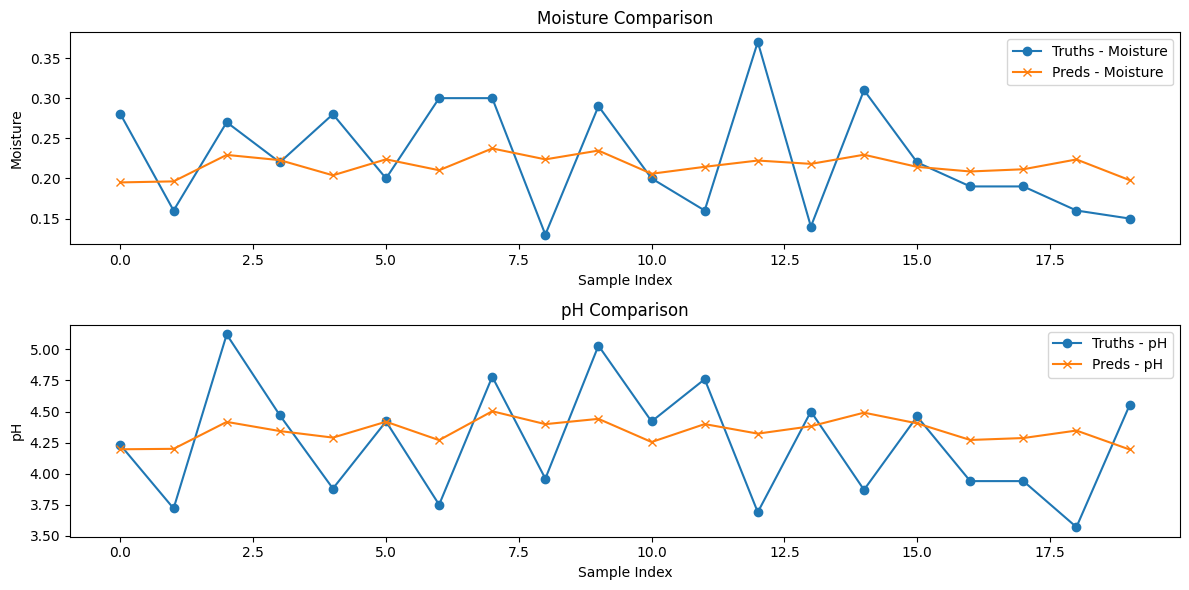

In [269]:

truths = []
preds = []
for i in range(SET*4):
    predictions = modelC.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions[0]))
# Separate moisture and pH values for plotting
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# Plotting the results
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()




In [270]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))

74.77928413567352
91.07497981394631


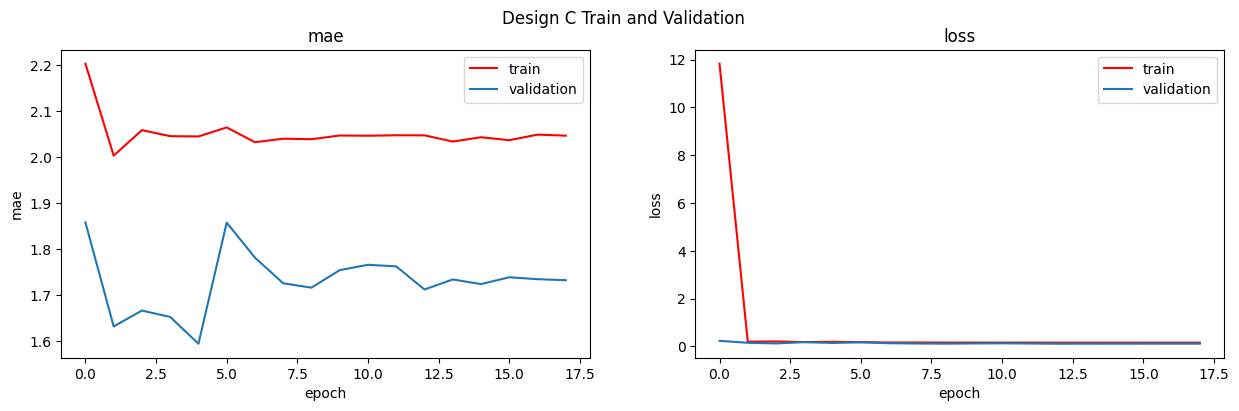

In [259]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.suptitle("Design C Train and Validation")

plt.subplot(121)
plt.plot(historyC.history['mae'], color ='r')
plt.plot(historyC.history['val_mae'])
plt.title('mae')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mae')

plt.subplot(122)
plt.plot(historyC.history['loss'], color ='r')
plt.plot(historyC.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()


In [260]:
## Design C
train_loss = historyC.history['loss']
train_mae = historyC.history['mae']
val_loss = historyC.history['val_loss']
val_mae = historyC.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train mae: {:.4f}".format(train_mae[best_epoch]))
print("Final Test mae: {:.4f}".format(val_mae[best_epoch]))


Best Epoch:  12
Final Train Loss: 0.1572
Final Validation Loss: 0.1122
Final Train mae: 2.0472
Final Test mae: 1.7128


In [261]:
# modelC_train_accuracy = get_model_accuracy(modelC, gen_X_values_3_1, y_values_1, X_values_1)
# print("Train Accuracy")
# print("Moisture: {:.2f}, pH: {:.2f}".format(modelC_train_accuracy[0], modelC_train_accuracy[1]))

# modelC_test_accuracy = get_model_accuracy(modelC, gen_X_values_3_2, y_values_2, X_values_2)
# print("Test Accuracy")
# print("Moisture: {:.2f}, pH: {:.2f}".format(modelC_test_accuracy[0], modelC_test_accuracy[1]))


In [262]:


# predictions = modelC.predict(np.array([SAMPLE[0][0]]))
# truth = unprocess_label_wmask(SAMPLE[0][0],SAMPLE[1][0], False)
# pred = unprocess_label_wmask(SAMPLE[0][0],predictions[0], False)
# print("TRUTH moisture: {:.2f}, ph: {:.2f}".format(truth[0],truth[1]))
# print("PREDICTIONS moisture: {:.2f}, ph: {:.2f}".format(pred[0],pred[1]))

In [263]:
# epochs = 512
# steps_per_epoch = 512 // batch_size + 1  # we usually consider 1 epoch to be
#                                             # the point where the model has seen
#                                             # all the training samples at least once
# min_lr = 1e-8
# factor = 0.1
# SCHEDULE_EPOCH = 200
# STEPS = 200

# historyC = {"history":{"loss":[],"mae":[],"val_loss":[],"val_mae":[]}}
# for e in range(epochs):
#     for i, (images, y_batch) in enumerate(train_generator):
#        new_y_batch = []
#        for x,img in enumerate(images):
#         array = np.ones(image_size+(3,))
#         array *= img>0
#         array[array>0] = y_batch[x]
#         new_y_batch.append(array)
#        new_y_batch = np.array(new_y_batch)
#        loss = modelC.train_on_batch(images, new_y_batch)  # train model for a single iteration
#     #    val = modelB.test_on_batch(images, new_y_batch)
#        if i >= steps_per_epoch:  # manually detect the end of the epoch
#             historyC["history"]["loss"].append(loss[0])
#             historyC["history"]["mae"].append(loss[1])
#             # print("EPOCH: {} LOSS: {:.6f} 2ND_METRIC: {:.6f}".format(e+1, loss[0], loss[1]))
#             break  
#     for i, (images, y_batch) in enumerate(val_generator):
#        new_y_batch = []
#        for x,img in enumerate(images):
#         array = np.ones(image_size+(3,))
#         array *= img>0
#         array[array>0] = y_batch[x]
#         new_y_batch.append(array)
#        new_y_batch = np.array(new_y_batch)
#     #    loss = modelB.train_on_batch(images, new_y_batch)  # train model for a single iteration
#        val = modelC.test_on_batch(images, new_y_batch)
#        if i >= steps_per_epoch:  # manually detect the end of the epoch
#             historyC["history"]["val_loss"].append(val[0])
#             historyC["history"]["val_mae"].append(val[1])
#             # print("EPOCH: {} LOSS: {:.6f} 2ND_METRIC: {:.6f}".format(e+1, loss[0], loss[1]))
#             curr_lr = modelC.optimizer.learning_rate
#             if e>=SCHEDULE_EPOCH and curr_lr>min_lr: 
#                K.set_value(modelC.optimizer.learning_rate, curr_lr*factor)
#                curr_lr = modelC.optimizer.learning_rate
#                SCHEDULE_EPOCH+=STEPS
#             # patience = 2
#             # if e>patience and curr_lr>min_lr:
#                # curr_loss = historyA["history"]["val_loss"][-1]
#                # for i in historyA["history"]["val_loss"][-patience-1:-1]:
#                #    if curr_loss >= i: patience-=1
#                #    if patience < 1:
#                      # K.set_value(modelA.optimizer.learning_rate, curr_lr*factor)
#                      # curr_lr = modelA.optimizer.learning_rate
#             break  
#     print("EPOCH: {} LOSS: {:.6f} MAE: {:.6f} VAL_LOSS: {:.6f} VAL_MAE: {:.6f}   CURR_LR {:.2E}".format(e+1, loss[0], loss[1],val[0],val[1], curr_lr.numpy()))
#     train_generator.on_epoch_end()  # this shuffles the data at the end of each epoch

In [264]:
# plt.figure(figsize=(10,4))

# plt.subplot(121)
# plt.plot(historyC["history"]["loss"][10:], color='g',alpha=.5)
# plt.plot(historyC["history"]["val_loss"][10:], color='r',alpha=.7)
# plt.legend(["Train","Val"])
# plt.ylabel("MSE")
# plt.xlabel("Epochs")

# plt.subplot(122)
# plt.plot(historyC["history"]["mae"][10:], color='g',alpha=.5)
# plt.plot(historyC["history"]["val_mae"][10:], color='r',alpha=.7)
# plt.legend(["Train","Val"])
# plt.ylabel("MAE")
# plt.xlabel("Epochs")

# plt.suptitle("Model C: DeepLabV3+")
# plt.show()

In [265]:
# sample = next(train_generator)
# result = modelC(sample[0])
# for x,i in enumerate(result):
#     RGB  = cv2.cvtColor(sample[0][x],cv2.COLOR_HSV2RGB)
#     MASK = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY) > 0
#     ARRAY = np.array(result[5]).reshape(image_size) * MASK
#     OUTPUT = np.array([x for x in ARRAY.flatten() if x > 0])
#     print(np.average(OUTPUT), np.average(sample[1][x]))

In [266]:
# modelC.save('design_models/designC.h5')

In [267]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [268]:
# modelC.save('design_models/designC_v6.h5')


## Evaluating Constraints

### MANUFACTURABILITY: TRAINING TIME

In [ ]:
# # modelA = tf.keras.models.load_model('design_models/designA_v7.h5')
# modelB = tf.keras.models.load_model('design_models/designB_v7.h5')
# # modelC = tf.keras.models.load_model('design_models/designC_v7.h5')


In [ ]:
# epochs = 128
# REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=5, min_lr=1e-9)
# ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, mode="min", restore_best_weights=True)

In [ ]:
# ## DESIGN A
# import time 
# start = time.time()
# historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

# # ## FUNCTIONALITY: INFERENCE TIME
# # modelC.evaluate(train_generator[1][0][0].reshape(1,32,32,3))

In [ ]:
# ## DESIGN B
# import time 
# start = time.time()
# historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

In [ ]:
# ## DESIGN C
# import time 
# start = time.time()
# historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

### ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND

In [ ]:
## Design A
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsA = get_flops(modelA, batch_size=1)
print(f"FLOPS: {flopsA}")

FLOPS: 492177674


In [ ]:
## Design B
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsB = get_flops(modelB, batch_size=1)
print(f"FLOPS: {flopsB}")

FLOPS: 1076748438


In [ ]:
## Design C
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsC = get_flops(modelC, batch_size=1)
print(f"FLOPS: {flopsC}")

FLOPS: 2257500296


### FUNCTIONALITY: INFERENCE TIME

In [ ]:
inference_sample = train_generator[1][0][0].reshape(1,128,128,3)

In [ ]:
import time
## Design A
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelA.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 20ms/step
Inference time: 235.0521ms


In [ ]:
## Design B
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelB.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 18ms/step
Inference time: 53.0114ms


In [ ]:
## Design AC
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelC.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 24ms/step
Inference time: 66.7467ms


### PERFORMANCE: COEFFICIENT OF DETERMINATION

In [ ]:
## Prepare set of x values and y values for performance constraint
X_values,y_values = [],[]
for i in range(10):
    values = next(val_generator)
    # for j in range(values[0].shape[0]):
    X_values.append(values[0])
    y_values.append(values[1])

## create X_values generator
gen_X_values_1 = (x for x in X_values)
gen_X_values_2 = (x for x in X_values)
gen_X_values_3 = (x for x in X_values)
y_values = [y  for y_set in y_values for y in y_set]
y_values_0 = np.array(y_values)[:,:,:,0]
y_values_1 = np.array(y_values)[:,:,:,1]

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

y_values = np.array(y_values)
predictionsA = modelA.predict(gen_X_values_1)

y_values_flat_0 = y_values[:, :, :, 0].flatten()
predictionsA_flat_0 = predictionsA[:, :, :, 0].flatten()

y_values_flat_1 = y_values[:, :, :, 1].flatten()
predictionsA_flat_1 = predictionsA[:, :, :, 1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsA_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsA_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")


10/10 [==============================] - 0s 43ms/step
R^2 for class 0: 0.5327
R^2 for class 1: 0.5218
Average R^2 score: 0.5273


In [ ]:
## Design B
## PERFORMANCE: COEFFICIENT OF DETERMINATION
from sklearn.metrics import roc_auc_score
predictionsB = modelB.predict(gen_X_values_2)

y_values_flat_0 = y_values[:, :, :, 0].flatten()
predictionsB_flat_0 = predictionsB[:, :, :, 0].flatten()

y_values_flat_1 = y_values[:, :, :, 1].flatten()
predictionsB_flat_1 = predictionsB[:, :, :, 1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsB_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsB_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")



10/10 [==============================] - 1s 18ms/step
R^2 for class 0: 0.4947
R^2 for class 1: 0.4940
Average R^2 score: 0.4943


In [ ]:
## Design B
## PERFORMANCE: COEFFICIENT OF DETERMINATION
from sklearn.metrics import roc_auc_score
predictionsC = modelC.predict(gen_X_values_3)

y_values_flat_0 = y_values[:, :, :, 0].flatten()
predictionsC_flat_0 = predictionsC[:, :, :, 0].flatten()

y_values_flat_1 = y_values[:, :, :, 1].flatten()
predictionsC_flat_1 = predictionsC[:, :, :, 1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsC_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsC_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")



10/10 [==============================] - 0s 22ms/step
R^2 for class 0: 0.4550
R^2 for class 1: 0.4748
Average R^2 score: 0.4649


### EFFICIENCY: STORAGE CONSUMPTION

In [ ]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsA = modelA.get_weights()
total_sizeA = 0
for weight in weightsA:
    total_sizeA += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeA*8e-6:.4f}")

Total model weight size in megabytes: 470.6279


In [ ]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsB = modelB.get_weights()
total_sizeB = 0
for weight in weightsB:
    total_sizeB += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeB*8e-6:.4f}")

Total model weight size in megabytes: 300.9896


In [ ]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsC = modelC.get_weights()
total_sizeC = 0
for weight in weightsC:
    total_sizeC += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeC*8e-6:.4f}")

Total model weight size in megabytes: 253.3653


In [343]:
modelB.save('design_models/designB_v10.h5')


## Saving final trained and constrained models

In [131]:
modelA.save('design_models/designA_v10.h5')
modelB.save('design_models/designB_v10.h5')
modelC.save('design_models/designC_v10.h5')

# Testing Accuracy of Models

In [ ]:
## Prepare set of x values and y values for performance constraint
X_values,y_values = [],[]
for i in range(100):
    values = next(val_generator)
    # for j in range(values[0].shape[0]):
    X_values.append(values[0])
    y_values.append(values[1])